In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as em
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from sklearn.cluster import OPTICS, KMeans
from scipy import stats
from tqdm import trange
from matplotlib import gridspec
import matplotlib as mpl
import dask
from scipy.stats import poisson
from sklearn.metrics import adjusted_rand_score
from daskify import Daskified
 

b


In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [3]:
unit_usrt_j = np.concatenate((unit_usrt1[good_indexes], unit_usrt2[good_indexes], unit_usrt3[good_indexes]), axis=0)
mean_usrt1 = np.array([[i.mean() for i in j] for j in unit_usrt1[good_indexes]])
mean_usrt2 = np.array([[i.mean() for i in j] for j in unit_usrt2[good_indexes]])
mean_usrt3 = np.array([[i.mean() for i in j] for j in unit_usrt3[good_indexes]])
mean_all_usrt = np.concatenate((mean_usrt1, mean_usrt2, mean_usrt3), axis=0)
norm_mean_all_usrt = (mean_all_usrt - np.min(mean_all_usrt, axis=-1)[:, np.newaxis])/(np.max(mean_all_usrt, axis=-1)[:, np.newaxis] - np.min(mean_all_usrt, axis=-1)[: ,np.newaxis])

In [4]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Fig4/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Fig4/230320_conc_models1.pkl', 'rb')).load()



In [5]:
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [6]:
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)



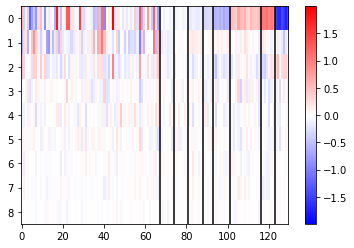

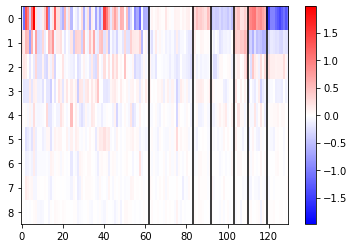

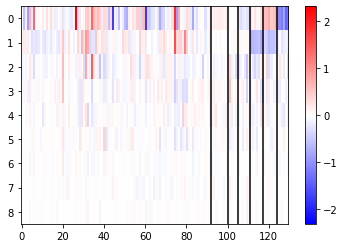

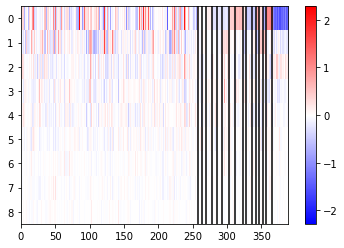

In [13]:
opts1 = OPTICS()
opts1.fit(fit_bins1[:, :2])
opts2 = OPTICS()
opts2.fit(fit_bins2[:, :2])
opts3 = OPTICS()
opts3.fit(fit_bins3[:, :2])
all_opts = OPTICS()
all_opts.fit(fit_bins_all[:, :2])
for opts, bins in zip([opts1, opts2, opts3, all_opts], [fit_bins1, fit_bins2, fit_bins3, fit_bins_all]):
    plt.figure()
    counts = []
    for i in np.unique(opts.labels_):
        counts.append(len(np.where(opts.labels_ == i)[0]))
    sorted_args = np.argsort(opts.labels_)
    vmax = np.max(np.array(bins))
    plt.imshow(np.array(bins).T[:, sorted_args], aspect='auto', cmap='bwr', interpolation='none', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    for i in np.cumsum(counts)[:-1]:
        plt.axvline(i, color='k')

Text(0.5, 0, 'PC1')

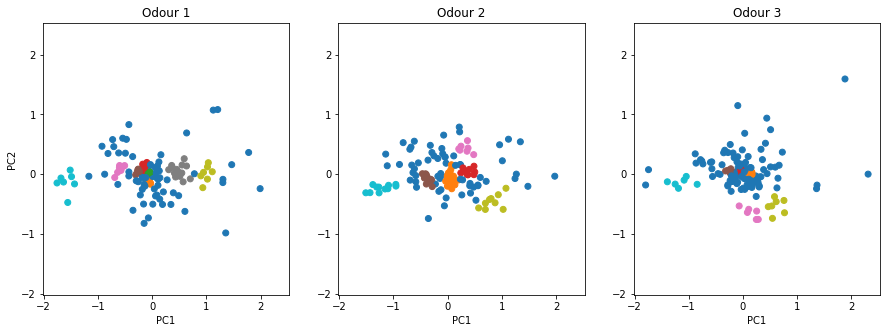

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(fit_bins1[:, 0], fit_bins1[:, 1], c=opts1.labels_, cmap='tab10')
ax[1].scatter(fit_bins2[:, 0], fit_bins2[:, 1], c=opts2.labels_, cmap='tab10')
ax[2].scatter(fit_bins3[:, 0], fit_bins3[:, 1], c=opts3.labels_, cmap='tab10')

max_lims = np.max([ax[0].get_xlim(), ax[1].get_xlim(), ax[2].get_xlim(), ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim()])
min_lims = np.min([ax[0].get_xlim(), ax[1].get_xlim(), ax[2].get_xlim(), ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim()])
ax[0].set_xlim(min_lims, max_lims)
ax[0].set_ylim(min_lims, max_lims)
ax[1].set_xlim(min_lims, max_lims)
ax[1].set_ylim(min_lims, max_lims)
ax[2].set_xlim(min_lims, max_lims)
ax[2].set_ylim(min_lims, max_lims)
ax[0].set_title('Odour 1')
ax[1].set_title('Odour 2')
ax[2].set_title('Odour 3')
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[2].set_xlabel('PC1')

In [35]:
def find_center_cluster(opts, bins):
    mean_point_distances = []
    for i in np.unique(opts.labels_):
        if i != -1:
            cluster_points = bins[np.where(opts.labels_ == i)[0], :2]
            mean_point = np.mean(cluster_points, axis=0)
            mean_point_distances.append(np.linalg.norm(mean_point))
    return mean_point_distances
cluster_centers1 = find_center_cluster(opts1, fit_bins1)
cluster_centers2 = find_center_cluster(opts2, fit_bins2)
cluster_centers3 = find_center_cluster(opts3, fit_bins3)

center_cluster1 = np.argmin(cluster_centers1)
center_cluster2 = np.argmin(cluster_centers2)
center_cluster3 = np.argmin(cluster_centers3)

nzcs1 = np.where(opts1.labels_ != center_cluster1)[0]
nzcs2 = np.where(opts2.labels_ != center_cluster2)[0]
nzcs3 = np.where(opts3.labels_ != center_cluster3)[0]

In [17]:
print(glyphs)

['▯▯▯▯▯', '▯▯▯▯▮', '▯▯▯▮▯', '▯▯▯▮▮', '▯▯▮▯▯', '▯▯▮▯▮', '▯▯▮▮▯', '▯▯▮▮▮', '▯▮▯▯▯', '▯▮▯▯▮', '▯▮▯▮▯', '▯▮▯▮▮', '▯▮▮▯▯', '▯▮▮▯▮', '▯▮▮▮▯', '▯▮▮▮▮', '▮▯▯▯▯', '▮▯▯▯▮', '▮▯▯▮▯', '▮▯▯▮▮', '▮▯▮▯▯', '▮▯▮▯▮', '▮▯▮▮▯', '▮▯▮▮▮', '▮▮▯▯▯', '▮▮▯▯▮', '▮▮▯▮▯', '▮▮▯▮▮', '▮▮▮▯▯', '▮▮▮▯▮', '▮▮▮▮▯', '▮▮▮▮▮']


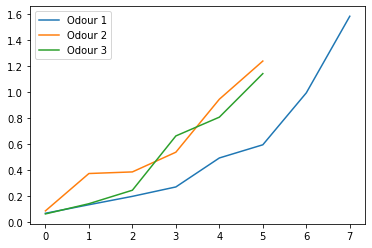

In [40]:
plt.plot(np.sort(cluster_centers1), label='Odour 1')
plt.plot(np.sort(cluster_centers2), label='Odour 2')
plt.plot(np.sort(cluster_centers3), label='Odour 3')
plt.legend()

Text(0.5, 0, 'PC1')

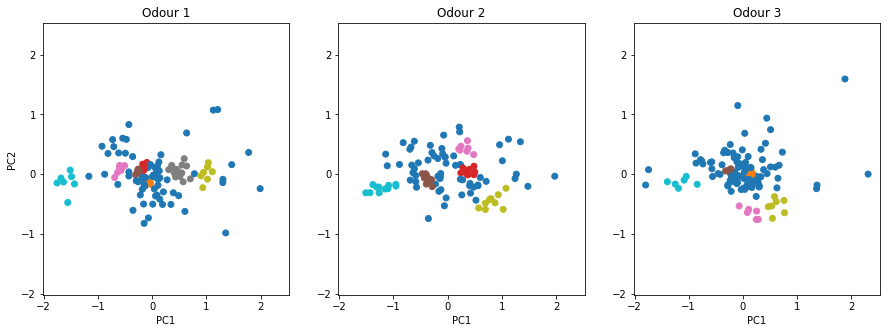

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(fit_bins1[nzcs1, 0], fit_bins1[nzcs1, 1], c=opts1.labels_[nzcs1], cmap='tab10')
ax[1].scatter(fit_bins2[nzcs2, 0], fit_bins2[nzcs2, 1], c=opts2.labels_[nzcs2], cmap='tab10')
ax[2].scatter(fit_bins3[nzcs3, 0], fit_bins3[nzcs3, 1], c=opts3.labels_[nzcs3], cmap='tab10')

max_lims = np.max([ax[0].get_xlim(), ax[1].get_xlim(), ax[2].get_xlim(), ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim()])
min_lims = np.min([ax[0].get_xlim(), ax[1].get_xlim(), ax[2].get_xlim(), ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim()])
ax[0].set_xlim(min_lims, max_lims)
ax[0].set_ylim(min_lims, max_lims)
ax[1].set_xlim(min_lims, max_lims)
ax[1].set_ylim(min_lims, max_lims)
ax[2].set_xlim(min_lims, max_lims)
ax[2].set_ylim(min_lims, max_lims)
ax[0].set_title('Odour 1')
ax[1].set_title('Odour 2')
ax[2].set_title('Odour 3')
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[2].set_xlabel('PC1')

Text(0.5, 0, 'Number of clusters')

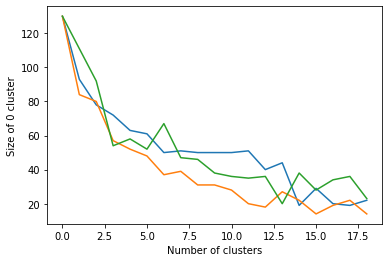

In [26]:
cluster_size1 = []
cluster_size2 = []
cluster_size3 = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(bins1)
    min_cluster = np.argmin(np.linalg.norm(kmeans.cluster_centers_, axis=-1))
    cluster_size1.append(len(fit_bins1[kmeans.labels_ == min_cluster]))

    kmeans.fit(bins2)
    min_cluster = np.argmin(np.linalg.norm(kmeans.cluster_centers_, axis=-1))    
    cluster_size2.append(len(fit_bins1[kmeans.labels_ == min_cluster]))

    kmeans.fit(bins3)
    min_cluster = np.argmin(np.linalg.norm(kmeans.cluster_centers_, axis=-1))    
    cluster_size3.append(len(fit_bins1[kmeans.labels_ == min_cluster]))


plt.plot(cluster_size1, label='O1')
plt.plot(cluster_size2, label='O2')
plt.plot(cluster_size3, label='O3')
plt.ylabel('Size of 0 cluster')
plt.xlabel('Number of clusters')

In [27]:
kmeans1 = KMeans(n_clusters=10)
kmeans1.fit(bins1)
kmeans2 = KMeans(n_clusters=10)
kmeans2.fit(bins2)
kmeans3 = KMeans(n_clusters=10)
kmeans3.fit(bins3)

KMeans(n_clusters=10)

In [28]:
print(np.argmin(np.linalg.norm(kmeans1.cluster_centers_, axis=1)))

5


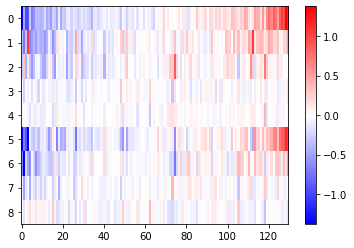

In [197]:
vmax = np.max(np.array(bins3))
plt.imshow(bins3.T[:, np.argsort(bins3.mean(axis=-1))], aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()

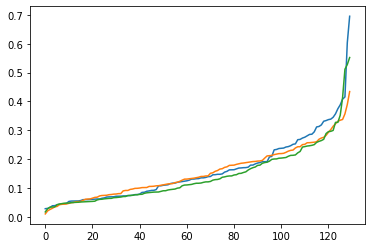

In [183]:
abs_mean_bins1 = np.mean(np.abs(bins1), axis=-1)
abs_mean_bins2 = np.mean(np.abs(bins2), axis=-1)
abs_mean_bins3 = np.mean(np.abs(bins3), axis=-1)
abs_mean_bins1.sort()
abs_mean_bins2.sort()
abs_mean_bins3.sort()
plt.plot(abs_mean_bins1)
plt.plot(abs_mean_bins2)
plt.plot(abs_mean_bins3)

5


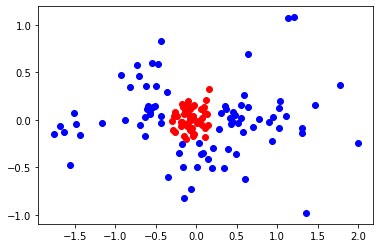

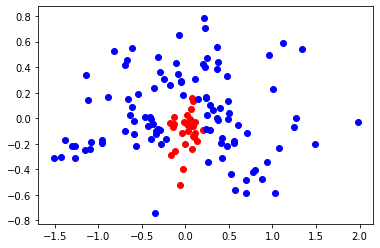

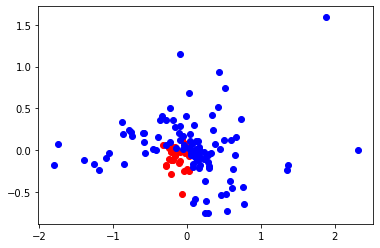

In [29]:
print(np.argmin(np.linalg.norm(kmeans1.cluster_centers_, axis=1)))
all_kmeans = [kmeans1, kmeans2, kmeans3]
all_fit_bins = [fit_bins1, fit_bins2, fit_bins3]

for kmeans, fit_bins in zip(all_kmeans, all_fit_bins):
    center_label = np.argmin(np.linalg.norm(kmeans.cluster_centers_, axis=1))
    plt.figure()
    plt.scatter(fit_bins[kmeans.labels_ == center_label, 0], fit_bins[kmeans.labels_ == center_label, 1], c='r')
    plt.scatter(fit_bins[kmeans.labels_ != center_label, 0], fit_bins[kmeans.labels_ != center_label, 1], c='b')

#plt.scatter(fit_bins2[kmeans1.labels_ != 2, 0], fit_bins2[opts2.labels_ != 2, 1], c=opts2.labels_[opts2.labels_ != 2])

[  0   1   2   3   4   5   7   8   9  11  12  13  14  15  16  17  19  20
  22  26  32  42  46  52  53  57  58  60  61  63  64  65  67  69  73  77
  82  84  86  89  97 112 128 129]
[  0   1   2   3   4   6   7   8   9  10  11  16  17  22  26  41  42  57
  58  61  64  68  73  82  90 124 127]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  17  20  22
  23  26  27  35  41  45  46  49  52  54  57  58  60  61  62  63  64  65
  66  67  68  69  70  73  78  79  86  89  90  97 100 101 128]


Text(0.5, 1.0, 'O3')

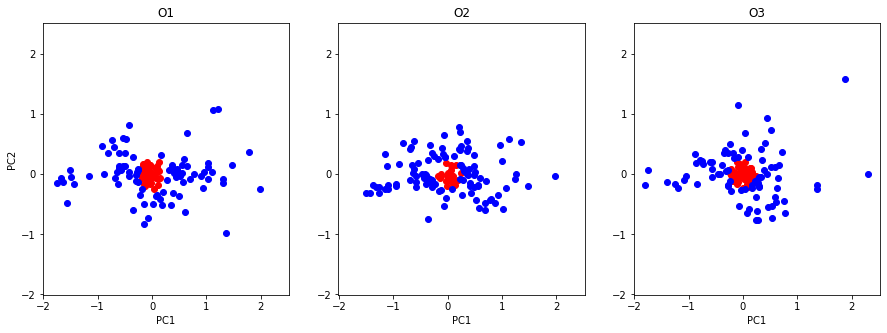

In [7]:
unresponsive_cells1 = np.where(np.linalg.norm(fit_bins1[:, :2], axis=-1) < 0.25)[0]
responsive_cells1 = np.where(np.linalg.norm(fit_bins1[:, :2], axis=-1) > 0.25)[0]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
print(unresponsive_cells1)
ax[0].scatter(fit_bins1[unresponsive_cells1, 0], fit_bins1[unresponsive_cells1, 1], c='r')
ax[0].scatter(fit_bins1[responsive_cells1, 0], fit_bins1[responsive_cells1, 1], c='b')

unresponsive_cells2 = np.where(np.linalg.norm(fit_bins2[:, :2], axis=-1) < 0.25)[0]
responsive_cells2 = np.where(np.linalg.norm(fit_bins2[:, :2], axis=-1) > 0.25)[0]
print(unresponsive_cells2)

ax[1].scatter(fit_bins2[unresponsive_cells2, 0], fit_bins2[unresponsive_cells2, 1], c='r')
ax[1].scatter(fit_bins2[responsive_cells2, 0], fit_bins2[responsive_cells2, 1], c='b')

unresponsive_cells3 = np.where(np.linalg.norm(fit_bins3[:, :2], axis=-1) < 0.25)[0]
responsive_cells3 = np.where(np.linalg.norm(fit_bins3[:, :2], axis=-1) > 0.25)[0]
print(unresponsive_cells3)

ax[2].scatter(fit_bins3[unresponsive_cells3, 0], fit_bins3[unresponsive_cells3, 1], c='r')
ax[2].scatter(fit_bins3[responsive_cells3, 0], fit_bins3[responsive_cells3, 1], c='b')

max_lims = np.max([ax[0].get_xlim(), ax[1].get_xlim(), ax[2].get_xlim(), ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim()])
min_lims = np.min([ax[0].get_xlim(), ax[1].get_xlim(), ax[2].get_xlim(), ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim()])
ax[0].set_xlim(min_lims, max_lims)
ax[0].set_ylim(min_lims, max_lims)
ax[1].set_xlim(min_lims, max_lims)
ax[1].set_ylim(min_lims, max_lims)
ax[2].set_xlim(min_lims, max_lims)
ax[2].set_ylim(min_lims, max_lims)
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[2].set_xlabel('PC1')
ax[0].set_title('O1')
ax[1].set_title('O2')
ax[2].set_title('O3')

In [8]:
all_unresponsive_cells = unresponsive_cells1.tolist() + unresponsive_cells2.tolist() + unresponsive_cells3.tolist()
all_responsive_cells = [i for i in range(130) if i not in all_unresponsive_cells]
all_responsive_cells_joined = all_responsive_cells + [i + 130 for i in all_responsive_cells] + [i + 260 for i in all_responsive_cells]
print(all_responsive_cells_joined)    

[18, 21, 24, 25, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 43, 44, 47, 48, 50, 51, 55, 56, 59, 71, 72, 74, 75, 76, 80, 81, 83, 85, 87, 88, 91, 92, 93, 94, 95, 96, 98, 99, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 148, 151, 154, 155, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 173, 174, 177, 178, 180, 181, 185, 186, 189, 201, 202, 204, 205, 206, 210, 211, 213, 215, 217, 218, 221, 222, 223, 224, 225, 226, 228, 229, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 278, 281, 284, 285, 288, 289, 290, 291, 293, 294, 296, 297, 298, 299, 300, 303, 304, 307, 308, 310, 311, 315, 316, 319, 331, 332, 334, 335, 336, 340, 341, 343, 345, 347, 348, 351, 352, 353, 354, 355, 356, 358, 359, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 385, 386]


In [69]:
print(len(all_unresponsive_cells), len(all_responsive_cells), len(responsive_cells1), len(responsive_cells2), len(responsive_cells3))

122 66 86 103 79


Text(0, 0.5, 'PC2')

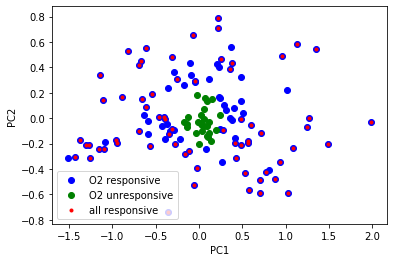

In [70]:


plt.scatter(fit_bins2[responsive_cells2, 0], fit_bins2[responsive_cells2, 1], c='b', label='O2 responsive')
plt.scatter(fit_bins2[unresponsive_cells2, 0], fit_bins2[unresponsive_cells2, 1], c='g', label='O2 unresponsive')
plt.scatter(fit_bins2[all_responsive_cells, 0], fit_bins2[all_responsive_cells, 1], c='r', marker='.', label='all responsive')

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

(-2.565188985143151, 2.565188985143151)

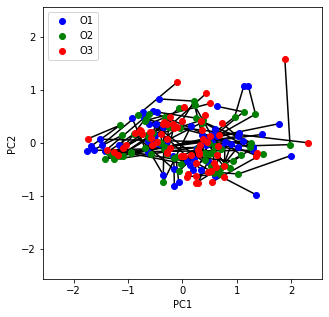

In [151]:
fig = plt.figure(figsize=(5, 5))
for i in all_responsive_cells:
    plt.plot([fit_bins1[i, 0], fit_bins2[i, 0], fit_bins3[i, 0]], [fit_bins1[i, 1], fit_bins2[i, 1], fit_bins3[i, 1]], c='k', zorder=-10)
plt.scatter(fit_bins1[all_responsive_cells, 0], fit_bins1[all_responsive_cells, 1], c='b', label='O1')
plt.scatter(fit_bins2[all_responsive_cells, 0], fit_bins2[all_responsive_cells, 1], c='g', label='O2')
plt.scatter(fit_bins3[all_responsive_cells, 0], fit_bins3[all_responsive_cells, 1], c='r', label='O3')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
max_lims = np.max(np.concatenate([np.abs(plt.xlim()), np.abs(plt.ylim())]))
plt.xlim([-max_lims, max_lims])
plt.ylim([-max_lims, max_lims])

(-2.565188985143151, 2.565188985143151)

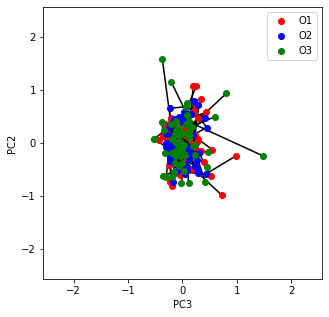

In [77]:
plt.figure(figsize=(5, 5))
for i in all_responsive_cells:
    plt.plot([fit_bins1[i, 2], fit_bins2[i, 2], fit_bins3[i, 2]], [fit_bins1[i, 1], fit_bins2[i, 1], fit_bins3[i, 1]], c='k', zorder=-10)
plt.scatter(fit_bins1[all_responsive_cells, 2], fit_bins1[all_responsive_cells, 1], c='r', label='O1')
plt.scatter(fit_bins2[all_responsive_cells, 2], fit_bins2[all_responsive_cells, 1], c='b', label='O2')
plt.scatter(fit_bins3[all_responsive_cells, 2], fit_bins3[all_responsive_cells, 1], c='g', label='O3')
plt.xlabel('PC3')
plt.ylabel('PC2')
plt.legend()

plt.xlim([-max_lims, max_lims])
plt.ylim([-max_lims, max_lims])

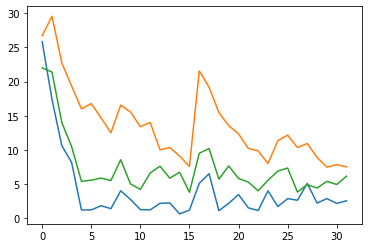

In [67]:
plt.plot(diff_models1[all_responsive_cells[-1]].true_resp)
plt.plot(diff_models3[all_responsive_cells[-1]].true_resp)
plt.plot(diff_models2[all_responsive_cells[-1]].true_resp)

In [69]:
np.save('230515_all_responsive_cells.npy', all_responsive_cells)

In [10]:
def generate_low_pc_response(models, low_pc_bins):
    low_pc_models = [deepcopy(i) for i in models]
    threshes = [i.opt_out.x[-1] for i in models]
    bins_thresh = [list(i) + [j] for i, j in zip(low_pc_bins, threshes)]
    [i.fit(W=j) for i, j in zip(low_pc_models, bins_thresh)];
    low_pc_preds = [i.pred_resp for i in low_pc_models];
    return low_pc_preds

low_pc_pred1 = generate_low_pc_response(diff_models1, bins_1_pc12)
low_pc_pred2 = generate_low_pc_response(diff_models2, bins_2_pc12)
low_pc_pred3 = generate_low_pc_response(diff_models3, bins_3_pc12)
all_low_pc_pred = low_pc_pred1 + low_pc_pred2 + low_pc_pred3


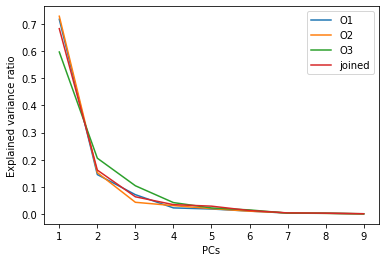

In [11]:
plt.plot(range(1, 10), pca1.explained_variance_ratio_, label='O1')
plt.plot(range(1, 10), pca2.explained_variance_ratio_, label='O2')
plt.plot(range(1, 10), pca3.explained_variance_ratio_, label='O3')
plt.plot(range(1, 10), pca_all.explained_variance_ratio_, label='joined')
plt.xlabel('PCs')
plt.ylabel('Explained variance ratio')
plt.legend()


In [12]:
print(np.cumsum(pca1.explained_variance_ratio_))
print(np.cumsum(pca2.explained_variance_ratio_))
print(np.cumsum(pca3.explained_variance_ratio_))
print(np.cumsum(pca_all.explained_variance_ratio_))

[0.71613886 0.86216548 0.9343968  0.95802687 0.97757818 0.98953994
 0.99432376 0.9984465  1.        ]
[0.72725748 0.88033273 0.92455717 0.95655112 0.97760495 0.98916225
 0.994405   0.99806369 1.        ]
[0.59599502 0.8020804  0.90699197 0.95015609 0.9735585  0.98977764
 0.99417144 0.99781403 1.        ]
[0.68171781 0.84411937 0.90852799 0.94414798 0.9741885  0.98822434
 0.99346672 0.99775386 1.        ]


Text(0, 0.5, 'Absolute correlation')

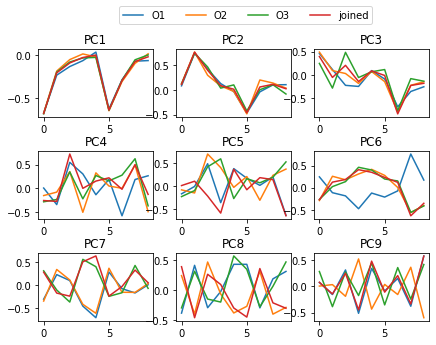

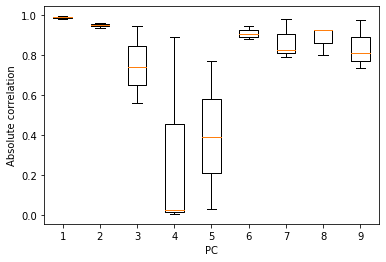

In [64]:
fig, ax = plt.subplots(3, 3, figsize=(7, 5))
fig.subplots_adjust(hspace=0.5)
axs = ax.ravel()
corrs = []
for i in range(9):
    
    axs[i].plot(pca1.components_[i], label='O1')
    axs[i].plot(pca2.components_[i], label='O2')
    axs[i].plot(pca3.components_[i], label='O3')
    axs[i].plot(pca_all.components_[i], label='joined')
    axs[i].set_title('PC{}'.format(i+1))
    flat_triag = np.triu(np.corrcoef([pca1.components_[i], pca2.components_[i], pca3.components_[i]]), 1).flatten()
    flat_triag = flat_triag[flat_triag != 0]
    corrs.append(flat_triag)
axs[1].legend(ncol=4, bbox_to_anchor=(1.75, 1.7))
plt.figure()
plt.boxplot(np.abs(corrs).T);
plt.xlabel('PC')
plt.ylabel('Absolute correlation')

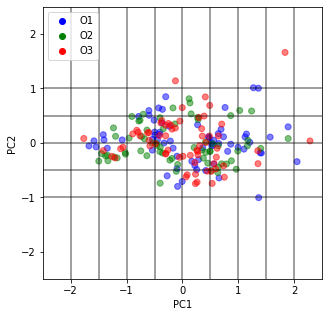

In [39]:
#colors = ['b' for i in range(390)]

#colors[380] = 'r' 
plt.figure(figsize=(5, 5))
# plt.scatter(fit_bins1[:, 0], fit_bins1[:, 1], c=colors, alpha=0.5)
# plt.scatter(fit_bins2[:, 0], fit_bins2[:, 1], c=colors, alpha=0.5)
# plt.scatter(fit_bins3[:, 0], fit_bins3[:, 1], c=colors, alpha=0.5)
# for i in range(130):
#     plt.plot([fit_bins_all[i, 0], fit_bins_all[i+130, 0], fit_bins_all[i+260, 0]], [fit_bins_all[i, 1], fit_bins_all[i+130, 1], fit_bins_all[i+260, 1]], c='k', zorder=0)
select_cells = all_responsive_cells_joined
colors = ['b' for i in range(int(len(select_cells)/3))] + ['g' for i in range(int(len(select_cells)/3))] + ['r' for i in range(int(len(select_cells)/3))]
plt.scatter(fit_bins_all[select_cells, 0], fit_bins_all[select_cells, 1], alpha=0.5, c=colors)


max_lims = np.max(np.concatenate([np.abs(plt.xlim()), np.abs(plt.ylim())]))
plt.xlim([-max_lims, max_lims])
plt.ylim([-max_lims, max_lims])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter([], [], color='b', label='O1')
plt.scatter([], [], color='g', label='O2')
plt.scatter([], [], color='r', label='O3')
plt.legend()
for index_i, i in enumerate(np.arange(-2, 2.5, 0.5)):
    plt.axvline(i, c='k', alpha=0.5)

for index_j, j in enumerate(np.arange(-1, 1.5, 0.5)):
    plt.axhline(j, c='k', alpha=0.5)

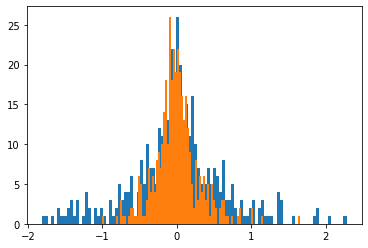

In [28]:
plt.hist(fit_bins_all[:, 0], bins=100);
plt.hist(fit_bins_all[:, 1], bins=100);

In [39]:
print(np.std(fit_bins_all[:, 0]))
print(np.std(fit_bins_all[:, 1]))

0.6283282207076082
0.30667568149037644


In [53]:
print(np.std(fit_bins_all[:, 0]))

0.6283282207076082


Text(0, 0.5, 'PD')

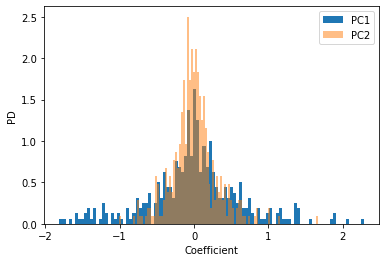

In [49]:
plt.hist(fit_bins_all[:, 0], bins=100, density=True, label='PC1');
plt.hist(fit_bins_all[:, 1], bins=100, density=True, alpha=0.5, label='PC2');
plt.legend()
plt.xlabel('Coefficient')
plt.ylabel('PD')

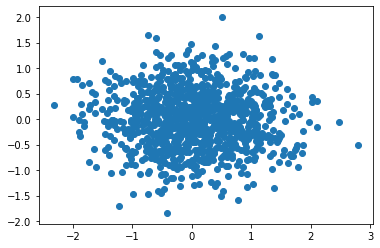

In [61]:
rands = np.random.multivariate_normal([0, 0], np.eye(2)*[0.628, 0.307], 1000)
plt.scatter(rands[:, 0], rands[:, 1])

Text(0, 0.5, 'PD')

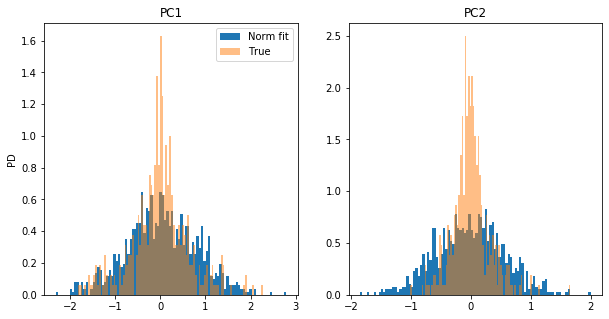

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(rands[:, 0], bins=100, label='Norm fit', density=True);
ax[0].hist(fit_bins_all[:, 0], bins=100, alpha=0.5, label='True', density=True);
ax[0].legend()
ax[1].hist(rands[:, 1], bins=100, label='Norm fit', density=True);
ax[1].hist(fit_bins_all[:, 1], bins=100, alpha=0.5, label='True', density=True);
ax[0].set_title('PC1')
ax[1].set_title('PC2')
ax[0].set_ylabel('PD')

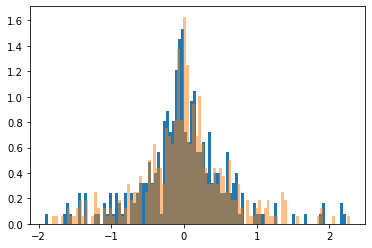

In [54]:
rand = np.random.laplace(0,0.445, 300)
plt.hist(rand, bins=100, density=True);
plt.hist(fit_bins_all[:, 0], bins=100, density=True, alpha=0.5);

Text(0, 0.5, 'PD')

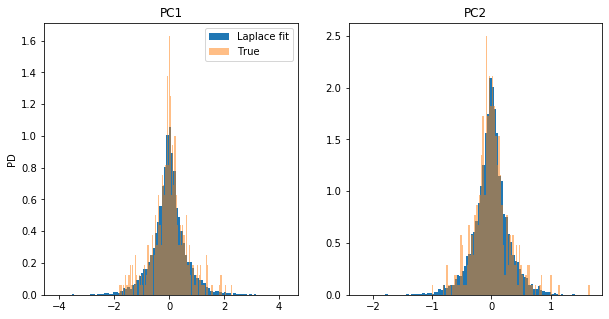

In [7]:
pc1_exp_decay = np.abs([i - np.median(fit_bins_all[:, 0]) for i in fit_bins_all[:, 0]]).mean()
pc2_exp_decay = np.abs([i - np.median(fit_bins_all[:, 1]) for i in fit_bins_all[:, 1]]).mean()
rand1 = np.random.laplace(0, pc1_exp_decay, 10000)
rand2 = np.random.laplace(0, pc2_exp_decay, 10000)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(rand1, bins=100, label='Laplace fit', density=True);
ax[0].hist(fit_bins_all[:, 0], bins=100, alpha=0.5, label='True', density=True);
ax[0].legend()
ax[1].hist(rand2, bins=100, label='Laplace fit', density=True);
ax[1].hist(fit_bins_all[:, 1], bins=100, alpha=0.5, label='True', density=True);
ax[0].set_title('PC1')
ax[1].set_title('PC2')
ax[0].set_ylabel('PD')


Text(0, 0.5, 'PC2')

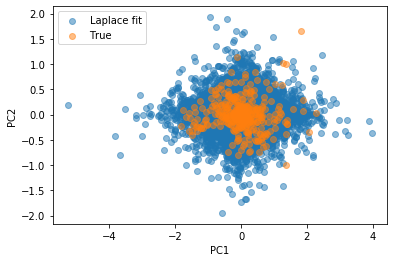

In [8]:
rand1 = np.random.laplace(0, pc1_exp_decay, 10000)
rand2 = np.random.laplace(0, pc2_exp_decay, 10000)
plt.scatter(rand1, rand2, alpha=0.5, label='Laplace fit');
plt.scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], alpha=0.5, label='True')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0.5, 1.0, 'Difference')

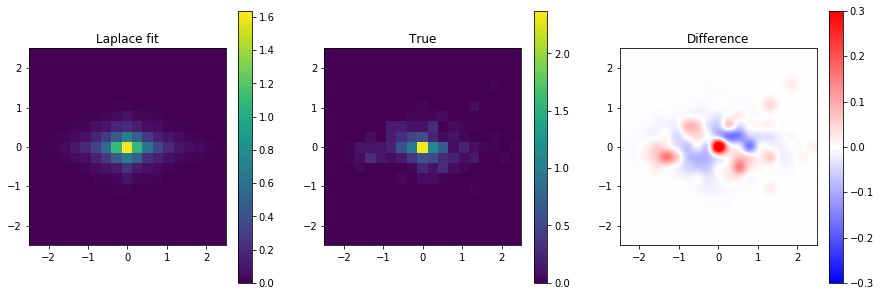

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
h, x, y, p  = ax[0].hist2d(rand1, rand2, bins=[np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20)], density=True);

h1, x1, y1, p1 = ax[1].hist2d(fit_bins_all[:, 0], fit_bins_all[:, 1], bins=[np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20)], density=True);
ax[0].set_aspect('equal') 
ax[1].set_aspect('equal')
vmax =0.3 #¢np.max(abs(h1-h))/2
im = ax[2].imshow(np.array(h1-h).T, cmap='bwr', vmax=vmax, vmin=-vmax, extent=[-2.5, 2.5, -2.5, 2.5], interpolation='gaussian', origin='lower')
plt.colorbar(ax=ax[0], mappable=p)
plt.colorbar(ax=ax[1], mappable=p1)
plt.colorbar(ax=ax[2], mappable=im)
ax[0].set_title('Laplace fit')
ax[1].set_title('True')
ax[2].set_title('Difference')



In [47]:
np.random.laplace.fit(fit_bins_all[:, 0])

AttributeError: 'builtin_function_or_method' object has no attribute 'fit'

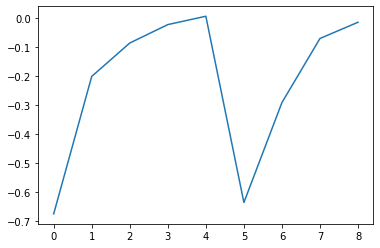

In [16]:
plt.plot(pca_all.components_[0], label='PC1')

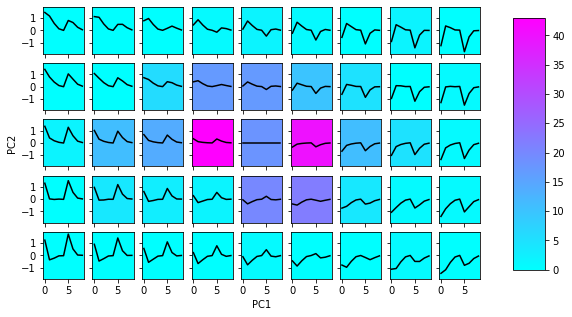

In [14]:
fig, ax = plt.subplots(5, 9 , figsize=(9, 5), sharex=True, sharey=True)
ws = []
select_cells = responsive_cells1.tolist() + [i + 130 for i in responsive_cells2.tolist()] + [i + 260 for i in responsive_cells3.tolist()]
counts = []
for index_i, i in enumerate(np.arange(-2, 2.5, 0.5)):
    for index_j, j in enumerate(np.arange(1, -1.5, -0.5)):
        count = np.where((fit_bins_all[select_cells, 0] < i+0.25) & (fit_bins_all[select_cells, 1] < j+0.25) 
                          & (fit_bins_all[select_cells, 0] >= i - 0.25) & (fit_bins_all[select_cells, 1] >= j - 0.25))[0].shape[0]
        ax[index_j, index_i].plot(pca_all.components_[0]*i + pca_all.components_[1]*j, c='k')
        ws.append(pca_all.components_[0]*i + pca_all.components_[1]*j)
        counts.append(count)
        ax[index_j, index_i].set_facecolor(mpl.cm.cool(count/max_counts))
max_counts = np.max(counts)
ax[2, 0].set_ylabel('PC2')
ax[4, 4].set_xlabel('PC1')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = mpl.colors.Normalize(vmin=0,vmax=max_counts)

sm = mpl.cm.ScalarMappable(cmap=mpl.cm.cool, norm=norm)
plt.colorbar(sm, cax=cbar_ax)

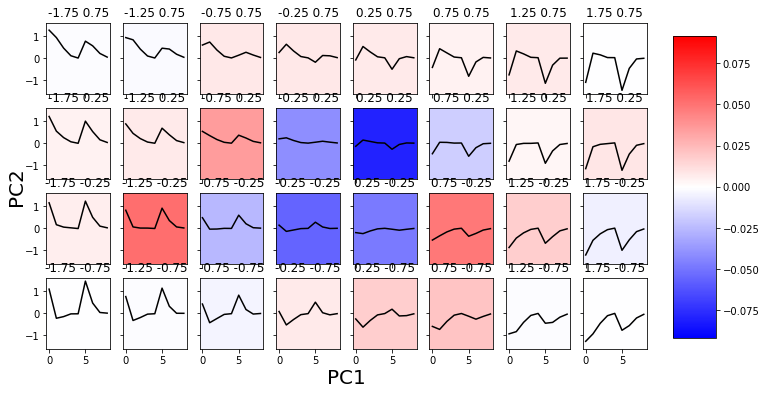

In [154]:
fig, ax = plt.subplots(4, 8 , figsize=(12, 6), sharex=True, sharey=True)
pc1_steps = np.arange(-2, 2.5, 0.5)
pc2_steps = np.arange(1, -1.5, -0.5)
select_cells = all_responsive_cells_joined
counts = []
density = True
comp = True
for i in range(len(pc1_steps)-1):
    for j in range(len(pc2_steps)-1):
        count = np.where((fit_bins_all[select_cells, 0] < pc1_steps[i+1]) & (fit_bins_all[select_cells, 1] >= pc2_steps[j+1]) 
                          & (fit_bins_all[select_cells, 0] >= pc1_steps[i]) & (fit_bins_all[select_cells, 1] < pc2_steps[j]))[0].shape[0]
        counts_lap = np.where((rand1 < pc1_steps[i+1]) & (rand2 >= pc2_steps[j+1])
                            & (rand1 >= pc1_steps[i]) & (rand2 < pc2_steps[j]))[0].shape[0]
        if density:
            count = count/len(select_cells)
            counts_lap = counts_lap/len(rand1)
        if comp:
            count = count - counts_lap
        #print(count)
        ax[j, i].plot(pca_all.components_[0]*(pc1_steps[i]+0.25) + pca_all.components_[1]*(pc2_steps[j]-0.25), c='k')
        #print(pca_all.components_[0]*pc1_steps[i]+0.25 + pca_all.components_[1]*pc2_steps[j]-0.25)
        if comp:
            ax[j, i].set_facecolor(mpl.cm.bwr(count/(2*max_counts) + 0.5))
        else:
            ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
        counts.append(count)
        ax[j, i].set_title(f'{pc1_steps[i]+0.25} {pc2_steps[j]-0.25}')

max_counts = np.max(np.abs(counts))
fig.add_subplot(111, frameon=False)
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1', labelpad=20, fontsize=20)
plt.ylabel('PC2', labelpad=20, fontsize=20)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
if comp:
    norm = mpl.colors.Normalize(vmin=-max_counts,vmax=max_counts)
    sm = mpl.cm.ScalarMappable(cmap=mpl.cm.bwr, norm=norm)
else:
    norm = mpl.colors.Normalize(vmin=0,vmax=max_counts)
    sm = mpl.cm.ScalarMappable(cmap=mpl.cm.bwr, norm=norm)
    



plt.colorbar(sm, cax=cbar_ax)

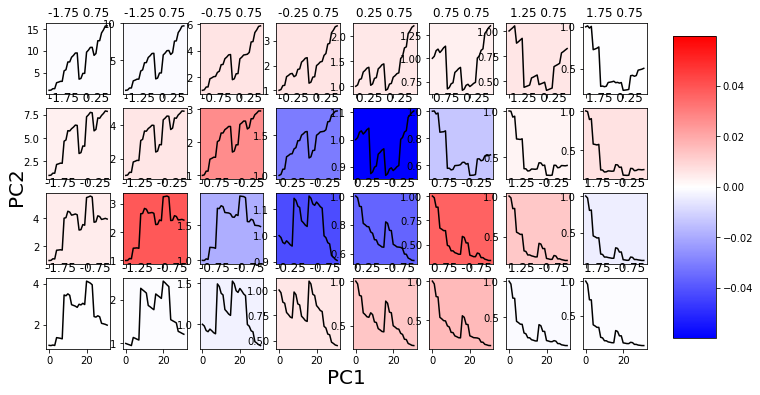

In [155]:
fig, ax = plt.subplots(4, 8 , figsize=(12, 6), sharex=True, sharey=False)
pc1_steps = np.arange(-2, 2.5, 0.5)
pc2_steps = np.arange(1, -1.5, -0.5)
select_cells = all_responsive_cells_joined
counts = []
density = True
comp = True

for i in range(len(pc1_steps)-1):
    for j in range(len(pc2_steps)-1):
        count = np.where((fit_bins_all[select_cells, 0] < pc1_steps[i+1]) & (fit_bins_all[select_cells, 1] >= pc2_steps[j+1]) 
                          & (fit_bins_all[select_cells, 0] >= pc1_steps[i]) & (fit_bins_all[select_cells, 1] < pc2_steps[j]))[0].shape[0]
        counts_lap = np.where((rand1 < pc1_steps[i+1]) & (rand2 >= pc2_steps[j+1])
                            & (rand1 >= pc1_steps[i]) & (rand2 < pc2_steps[j]))[0].shape[0]
        
        w = pca_all.components_[0]*(pc1_steps[i]+0.25) + pca_all.components_[1]*(pc2_steps[j]-0.25)
        pred = np.exp(diff_models1[0].trial_array @ w)

        if density:
            count = count/len(select_cells)
            counts_lap = counts_lap/len(rand1)
        if comp:
            count = count - counts_lap
        ax[j, i].plot(pred, c='k')
        #print(pca_all.components_[0]*pc1_steps[i]+0.25 + pca_all.components_[1]*pc2_steps[j]-0.25)
        if comp:
            ax[j, i].set_facecolor(mpl.cm.bwr(count/(2*max_counts) + 0.5))
        else:
            ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
        counts.append(count)
        ax[j, i].set_title(f'{pc1_steps[i]+0.25} {pc2_steps[j]-0.25}')
max_counts = np.max(counts)
fig.add_subplot(111, frameon=False)
plt.xticks([])
plt.yticks([])
plt.xlabel('PC1', labelpad=20, fontsize=20)
plt.ylabel('PC2', labelpad=20, fontsize=20)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
if comp:
    norm = mpl.colors.Normalize(vmin=-max_counts,vmax=max_counts)
    sm = mpl.cm.ScalarMappable(cmap=mpl.cm.bwr, norm=norm)
else:
    norm = mpl.colors.Normalize(vmin=0,vmax=max_counts)
    sm = mpl.cm.ScalarMappable(cmap=mpl.cm.bwr, norm=norm)
plt.colorbar(sm, cax=cbar_ax)

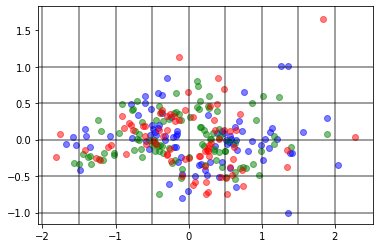

In [51]:
plt.scatter(fit_bins_all[responsive_cells1, 0], fit_bins_all[responsive_cells1, 1], c='b', alpha=0.5)
plt.scatter(fit_bins_all[responsive_cells2+130, 0], fit_bins_all[responsive_cells2+130, 1], c='g', alpha=0.5)
plt.scatter(fit_bins_all[responsive_cells3+260, 0], fit_bins_all[responsive_cells3+260, 1], c='r', alpha=0.5)
for index_i, i in enumerate(np.arange(-2, 2.5, 0.5)):
    plt.axvline(i, c='k', alpha=0.5)

for index_j, j in enumerate(np.arange(-1, 1.5, 0.5)):
    plt.axhline(j, c='k', alpha=0.5)

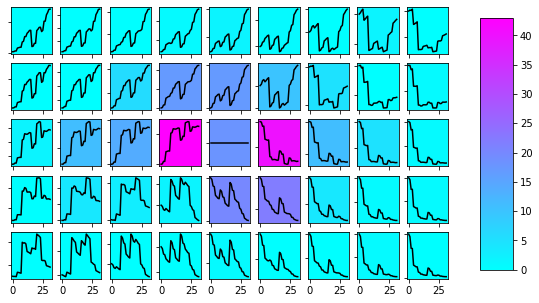

In [54]:
fig, ax = plt.subplots(5, 9 , figsize=(9, 5), sharex=True)
select_cells = responsive_cells1.tolist() + [i + 130 for i in responsive_cells2.tolist()] + [i + 260 for i in responsive_cells3.tolist()]
counts = []
for index_i, i in enumerate(np.arange(-2, 2.5, 0.5)):
    for index_j, j in enumerate(np.arange(1, -1.5, -0.5)):
        w = pca_all.components_[0]*i + pca_all.components_[1]*j
        pred = np.exp(diff_models1[0].trial_array @ w)
        ax[index_j, index_i].plot(pred, c='k')
        count = np.where((fit_bins_all[select_cells, 0] < i+0.25) & (fit_bins_all[select_cells, 1] < j+0.25) 
                          & (fit_bins_all[select_cells, 0] >= i - 0.25) & (fit_bins_all[select_cells, 1] >= j - 0.25))[0].shape[0]
        counts.append(count)
        ax[index_j, index_i].set_facecolor(mpl.cm.cool(count/max_counts))
        ax[index_j, index_i].set_yticklabels([])
max_counts = np.max(counts)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = mpl.colors.Normalize(vmin=0,vmax=max_counts)

sm = mpl.cm.ScalarMappable(cmap=mpl.cm.cool, norm=norm)
plt.colorbar(sm, cax=cbar_ax)

11


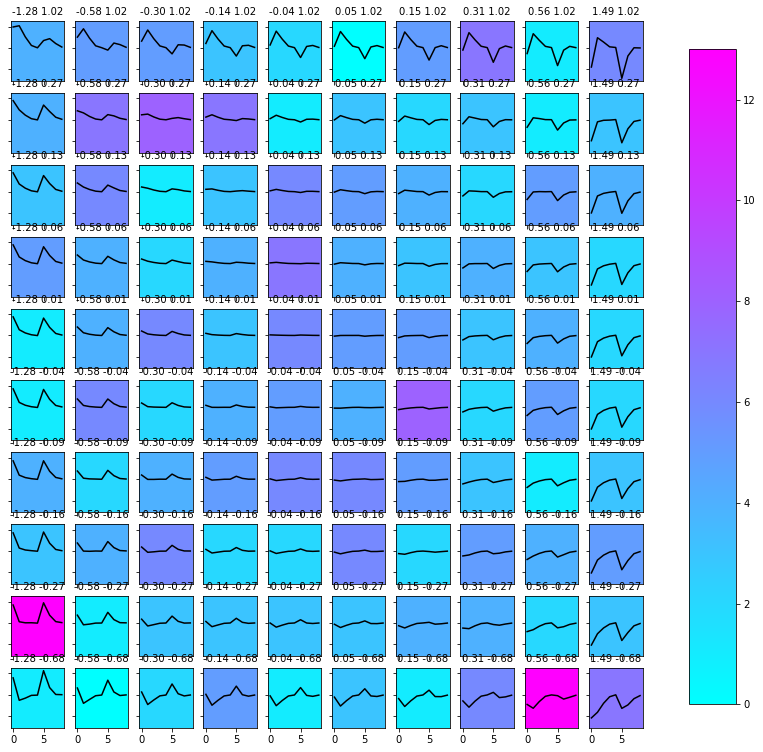

In [29]:
fig, ax = plt.subplots(10, 10, figsize=(13, 13), sharex=True, sharey=True)
pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.1)]
print(len(pc1_quants))
pc2_quants = pc2_quants[::-1]
counts = []
select_cells = range(390)
for i in range(len(pc1_quants)-1):
    for j in range(len(pc2_quants)-1):
        count = np.where((fit_bins_all[select_cells, 0] < pc1_quants[i+1]) & (fit_bins_all[select_cells, 1] >= pc2_quants[j+1]) 
                          & (fit_bins_all[select_cells, 0] >= pc1_quants[i]) & (fit_bins_all[select_cells, 1] < pc2_quants[j]))[0].shape[0]
        counts_lap = np.where((rand1 < pc1_quants[i+1]) & (rand2 >= pc2_quants[j+1])
                            & (rand1 >= pc1_quants[i]) & (rand2 < pc2_quants[j]))[0].shape[0]
        
        #count = np.where((fit_bins_all[:, 0] < i+0.05) & (fit_bins_all[:, 1] < j+0.05) & (fit_bins_all[:, 0] >= i - 0.05) & (fit_bins_all[:, 1] >= j - 0.05))[0].shape[0]
        counts.append(count)
        #print(count)
        w = pca_all.components_[0]*((pc1_quants[i]+pc1_quants[i+1])/2) + pca_all.components_[1]*((pc2_quants[j]+pc2_quants[j+1])/2)
        ax[j, i].plot(w, c='k')
        ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
        ax[j, i].set_yticklabels([])
        ax[j, i].set_title(f'{(pc1_quants[i]+pc1_quants[i+1])/2:.2f} {(pc2_quants[j]+pc2_quants[j+1])/2:.2f}', fontsize=10)
counts = np.array(counts)
max_counts = np.max(counts)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = mpl.colors.Normalize(vmin=0,vmax=max_counts)

sm = mpl.cm.ScalarMappable(cmap=mpl.cm.cool, norm=norm)
plt.colorbar(sm, cax=cbar_ax)

Text(0, 0.5, 'PC2')

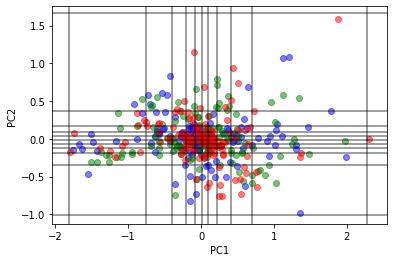

In [28]:
plt.scatter(fit_bins1[:, 0], fit_bins1[:, 1], alpha=0.5, c='b')
plt.scatter(fit_bins2[:, 0], fit_bins2[:, 1], alpha=0.5, c='g')
plt.scatter(fit_bins3[:, 0], fit_bins3[:, 1], alpha=0.5, c='r')

for i in pc1_quants:
    plt.axvline(i, c='k', alpha=0.5)
for i in pc2_quants:
    plt.axhline(i, c='k', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')

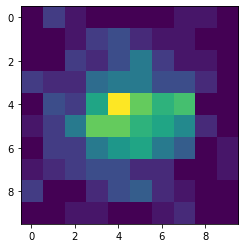

In [53]:
plt.imshow(counts)

In [ ]:
pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.05)]
pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.05)]
pc2_quants = pc2_quants[::-1]
cell_pred_fit = []
cell_pred_coords = []
for i in range(len(pc1_quants)-1):
    for j in range(len(pc2_quants)-1):
        w = pca_all.components_[0]*((pc1_quants[i]+pc1_quants[i+1])/2) + pca_all.components_[1]*((pc2_quants[j]+pc2_quants[j+1])/2)
        pred_fits = np.exp(diff_models1[0].trial_array @ w)
        cell_pred_fit.append((pred_fits - np.min(pred_fits))/(np.max(pred_fits) - np.min(pred_fits)))
        cell_pred_coords.append([(pc1_quants[i]+pc1_quants[i+1])/2, (pc2_quants[j]+pc2_quants[j+1])/2])

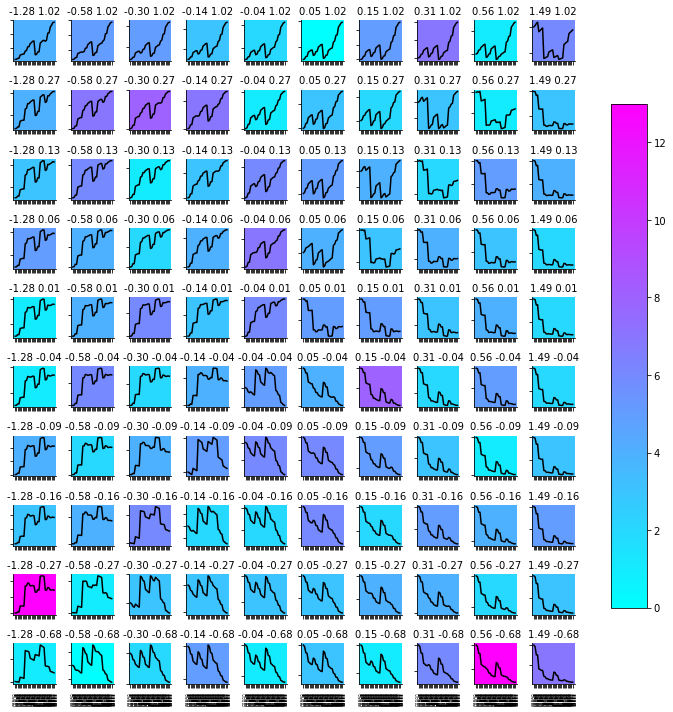

In [45]:

fig, ax = plt.subplots(10, 10, figsize=(10, 10), sharex=True, sharey=False)
pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = pc2_quants[::-1]
counts = []
density = False
comp = False
select_cells = range(390)
for i in range(len(pc1_quants)-1):
    for j in range(len(pc2_quants)-1):
        count = np.where((fit_bins_all[select_cells, 0] < pc1_quants[i+1]) & (fit_bins_all[select_cells, 1] >= pc2_quants[j+1]) 
                          & (fit_bins_all[select_cells, 0] >= pc1_quants[i]) & (fit_bins_all[select_cells, 1] < pc2_quants[j]))[0].shape[0]
        counts_lap = np.where((rand1 < pc1_quants[i+1]) & (rand2 >= pc2_quants[j+1])
                            & (rand1 >= pc1_quants[i]) & (rand2 < pc2_quants[j]))[0].shape[0]
        
        #count = np.where((fit_bins_all[:, 0] < i+0.05) & (fit_bins_all[:, 1] < j+0.05) & (fit_bins_all[:, 0] >= i - 0.05) & (fit_bins_all[:, 1] >= j - 0.05))[0].shape[0]
        #print(count)
        if density:
            count = count/len(select_cells)
            counts_lap = counts_lap/len(rand1)
        if comp:
            count = count - counts_lap
        #print(pca_all.components_[0]*pc1_steps[i]+0.25 + pca_all.components_[1]*pc2_steps[j]-0.25)
        counts.append(count)
        if comp:    
            ax[j, i].set_facecolor(mpl.cm.bwr(count/(2*max_counts) + 0.5))
        else:
            ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
        w = pca_all.components_[0]*((pc1_quants[i]+pc1_quants[i+1])/2) + pca_all.components_[1]*((pc2_quants[j]+pc2_quants[j+1])/2)
        pred_fits = np.exp(diff_models1[0].trial_array @ w)
        ax[j, i].plot(pred_fits,c='k')
        # ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
        ax[j, i].set_yticklabels([])
        ax[j, i].set_title(f'{(pc1_quants[i]+pc1_quants[i+1])/2:.2f} {(pc2_quants[j]+pc2_quants[j+1])/2:.2f}', fontsize=10)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
counts = np.array(counts)
max_counts = np.max(counts)
[i.set_xticks(range(32)) for i in ax[-1, :]]
[i.set_xticklabels(glyphs, rotation=90, fontsize=5) for i in ax[-1, :]]
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
if comp:
    norm = mpl.colors.Normalize(vmin=-max_counts,vmax=max_counts)
    sm = mpl.cm.ScalarMappable(cmap=mpl.cm.bwr, norm=norm)
else:
    norm = mpl.colors.Normalize(vmin=0,vmax=max_counts)
    sm = mpl.cm.ScalarMappable(cmap=mpl.cm.cool, norm=norm)
plt.colorbar(sm, cax=cbar_ax)


In [69]:
print(len(cell_pred_fit))

400


In [8]:
## clustering

pc1_steps = np.arange(-2.0, 2.1, 0.05)
pc2_steps = np.arange(-2.0, 2.1, 0.05)
pc2_steps = pc2_steps[::-1]
select_cells = range(390)
all_pred_fits = []
pred_fit_coords = []
all_ws = []
for i in range(len(pc1_steps)-1):
    for j in range(len(pc2_steps)-1):
        w = pca_all.components_[0]*((pc1_steps[i]+pc1_steps[i+1])/2) + pca_all.components_[1]*((pc2_steps[j]+pc2_steps[j+1])/2)
        pred_fits = np.exp(diff_models1[0].trial_array @ w)
        all_pred_fits.append((pred_fits - np.min(pred_fits))/(np.max(pred_fits) - np.min(pred_fits)))
        pred_fit_coords.append([(pc1_steps[i]+pc1_steps[i+1])/2, (pc2_steps[j]+pc2_steps[j+1])/2])

In [60]:
print(len(pc1_steps))

80


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
from scipy.spatial.distance import cdist

# silhs = []
# inerts = []

# for i in range(2, 15):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(np.array(all_pred_fits))
#     silhs.append(silhouette_score(np.array(all_pred_fits), kmeans.labels_))
#     inerts.append(kmeans.inertia_)
#     print(i)

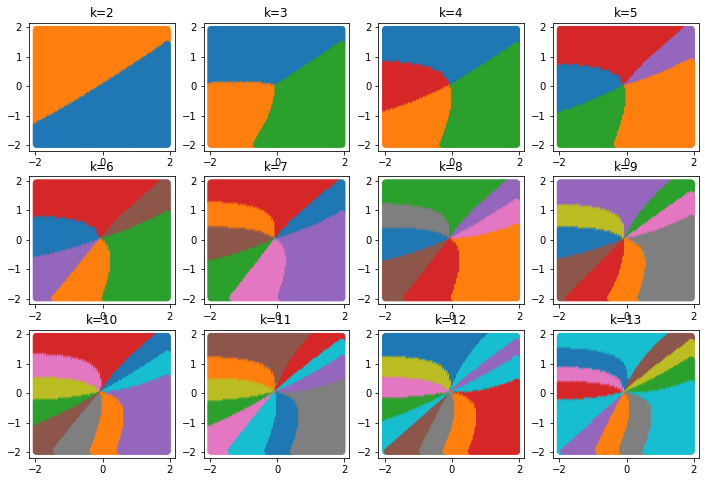

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
ax = ax.ravel()
for j in range(2, 14):
    kmeans = KMeans(n_clusters=j)
    kmeans.fit(np.array(all_pred_fits))
    cs = [mpl.cm.tab10(i) for i in kmeans.labels_]
    ax[j-2].scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs)
    ax[j-2].set_title(f'k={j}')

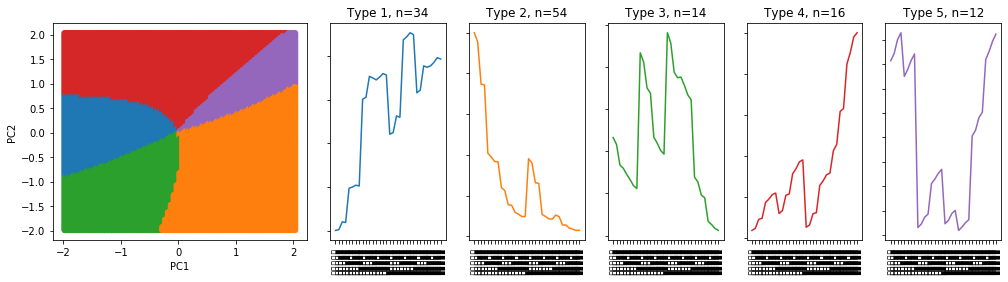

In [9]:
num_clusters =5
fig = plt.figure(figsize=(17, 4))
gs = gridspec.GridSpec(1, 7)
sc_ax = fig.add_subplot(gs[:2])
kmeans = KMeans(n_clusters=num_clusters, random_state=1020)
kmeans.fit(np.array(all_pred_fits))
cs = [mpl.cm.tab10(i) for i in kmeans.labels_]
sc_ax.scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs)
sc_ax.set_xlabel('PC1')
sc_ax.set_ylabel('PC2')
ax1 = fig.add_subplot(gs[2])
ax2 = fig.add_subplot(gs[3])
ax3 = fig.add_subplot(gs[4])
ax4 = fig.add_subplot(gs[5])
ax5 = fig.add_subplot(gs[6])

axs = [ax1, ax2, ax3, ax4, ax5]
[i.set_xticks(range(32)) for i in axs]
[i.set_xticklabels(glyphs, rotation=90) for i in axs]
[i.set_yticklabels([]) for i in axs]
kpreds = kmeans.predict(np.array(norm_mean_all_usrt))
for i in range(num_clusters):
    axs[i].plot(np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0), c=mpl.cm.tab10(i))
    axs[i].set_title(f'Type {i+1}, n={len(np.where(kpreds[:130] == i)[0])}')


In [12]:
np.save('230608_kmeans_pred_labels.npy', kpreds)

In [16]:
print(adjusted_rand_score(kpreds[:130], kpreds[130:260]))
print(adjusted_rand_score(kpreds[:130], kpreds[260:]))
print(adjusted_rand_score(kpreds[130:260], kpreds[260:]))

0.12109608372387971
0.05845247858625511
0.1903828985446328


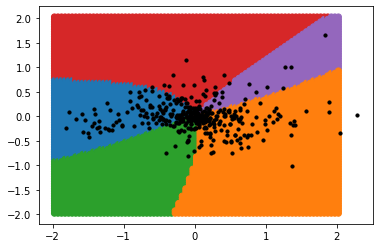

In [17]:
joined_unresponsive_cells = list(unresponsive_cells1) + [i+130 for i in unresponsive_cells2] + [i+260 for i in unresponsive_cells3]
joined_responsive_cells = list(responsive_cells1) + [i+130 for i in responsive_cells2] + [i+260 for i in responsive_cells3]
plt.scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs)
plt.scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], c='k', s=10)

In [18]:
rand_ws = rand1 
w = np.dot(pca_all.components_[0][:, np.newaxis], rand1[np.newaxis, :]) + np.dot(pca_all.components_[1][:, np.newaxis], rand2[np.newaxis, :])
w = w.T

pred_fits_rand = [np.exp(diff_models1[0].trial_array @ j) for j in w]
pred_fits_rand_norm = [(i - np.min(i))/(np.max(i) - np.min(i)) for i in pred_fits_rand]
kpred_rand = kmeans.predict(np.array(pred_fits_rand_norm))
kpred_fracs_rand = [len(np.where(kpred_rand == i)[0]) for i in range(num_clusters)]
kpred_fracs_rand = np.array(kpred_fracs_rand)/np.sum(kpred_fracs_rand)

kpred_fracs = [len(np.where(kpreds[joined_responsive_cells] == i)[0]) for i in range(num_clusters)]
kpred_fracs = np.array(kpred_fracs)/np.sum(kpred_fracs)
print(kpred_fracs_rand, kpred_fracs)

[0.3301 0.3358 0.133  0.1218 0.0793] [0.3619403  0.38059701 0.0858209  0.11940299 0.05223881]


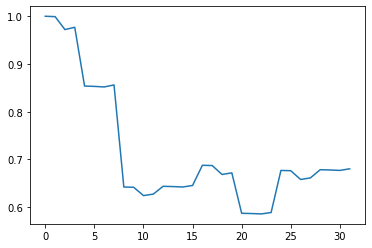

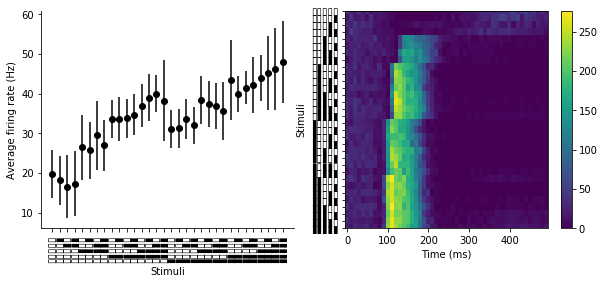

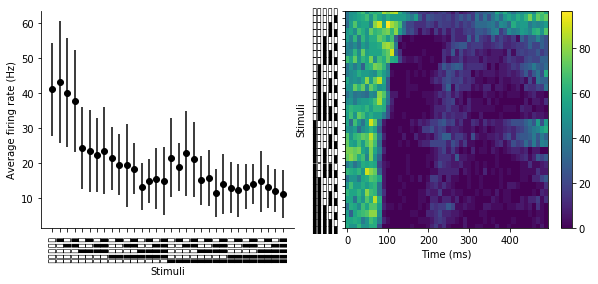

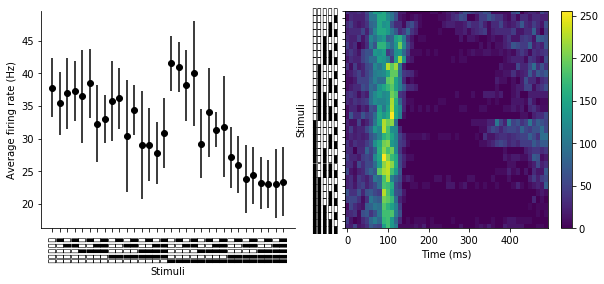

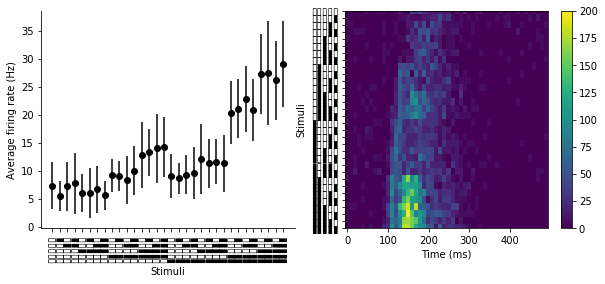

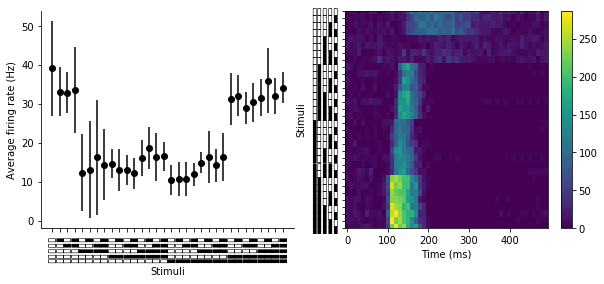

In [50]:
def plot_selected_cell_response(usrt_joined, cell_index, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    select_cell = usrt_joined[cell_index]
    cell_stds = [np.std(i.mean(axis=-1)) for i in select_cell]
    cell_means = [np.mean(i.mean(axis=-1)) for i in select_cell]
    ax.errorbar(range(32), cell_means, yerr=cell_stds, c='k', fmt='o')
    ax.set_xticks(range(32))
    ax.set_xticklabels(glyphs, rotation=90)
    ax.set_ylabel('Average firing rate (Hz)')
    ax.set_xlabel('Stimuli')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_selected_cell_heatmap(usrt_joined, cell_index, trial_indexes=range(32), ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    select_cell = usrt_joined[cell_index]
    cell_means = [i.mean(axis=0) for i in select_cell]
    im = ax.imshow(cell_means, aspect='auto', cmap='viridis')
    plt.colorbar(mappable=im, ax=ax)
    ax.set_yticks(range(32))
    ax.set_yticklabels(glyphs)
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([0, 100, 200, 300, 400])
    ax.set_ylabel('Stimuli')
    ax.set_xlabel('Time (ms)')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_selected_cell_response(unit_usrt_j, 348, ax=ax[0])
plot_selected_cell_heatmap(unit_usrt_j, 348, ax=ax[1])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_selected_cell_response(unit_usrt_j, 162, ax=ax[0])
plot_selected_cell_heatmap(unit_usrt_j, 162, ax=ax[1])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_selected_cell_response(unit_usrt_j, 233, ax=ax[0])
plot_selected_cell_heatmap(unit_usrt_j, 233, ax=ax[1])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_selected_cell_response(unit_usrt_j, 50, ax=ax[0])
plot_selected_cell_heatmap(unit_usrt_j, 50, ax=ax[1])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_selected_cell_response(unit_usrt_j, 37, ax=ax[0])
plot_selected_cell_heatmap(unit_usrt_j, 37, ax=ax[1])

#plt.plot(norm_mean_all_usrt[37], c='k')
#print(ui)


In [48]:
diff_tot = np.sum(np.abs(norm_mean_all_usrt - np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == 3)[0]], axis=0)), axis=-1)
print(np.argsort(diff_tot))


[ 50 180 356 122 383 231 353  91  81 219 382 227 257 308  51 259 207 213
  49 310 147 192  36 284 305 157 184 123 316 319 178 307  52  39  37 211
 314 164 182 187 127 179 300 276 302 328  63 201 175 112 322 129 324  46
 252 354 315 387 221  64 281  60  65 285 217 120  97  58 364  53 348 385
 135  69  86  87 389 309 189 286 216 190  45 242 128  67 372 193 355 208
 373  83 288  57 264 114  47 130  78 271 267 287 118 275  71 199 212 280
  82 277 238 320 102 282 240   6 195 161 183 142 345 110 169 239 298 265
 237 113 188 370 166 197 145  20 150 196 250 232 255 362 194 331 134   5
  89 278 323 294 106  77 116 388 186  48 139 158 273  22 241 108 124 167
  15 246  34 380 243 248 105 360   7 117 338 198 258 119 141 107  19 236
 149 191 115 272  38  40 303 109 376  32 367 371 204 244 156  33 297   4
 136 270 349 301 254 185 111 144 235 177 361 274  79 143 344 103 126 247
   2 256 296 374  76  62 304 343 261 101 209  59  14 131   9 325 222 378
   1   8 251 121 295 330  90 262  80  74 170 327 26

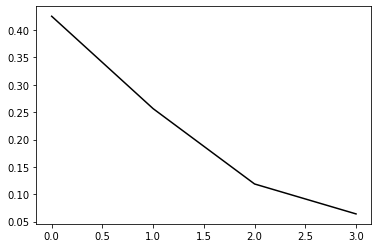

In [278]:
archtype_plots = [np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0) for i in range(5)]

plt.plot(np.array(archtype_plots)[3, iti_trials], c='k')

In [291]:

iti_trials = [24, 20, 18, 17]
onset_trials = [16, 8, 4, 2, 1]
conc_trials = [16, 24, 28, 30, 31]
for i in conc_trials:
    print(glyphs[i])

▮▯▯▯▯
▮▮▯▯▯
▮▮▮▯▯
▮▮▮▮▯
▮▮▮▮▮


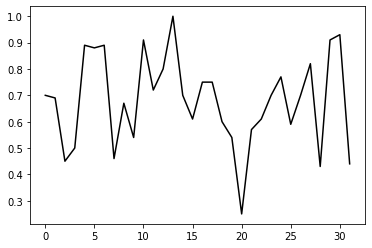

In [26]:
plt.plot(mean_all_usrt[1]/np.max(mean_all_usrt[1]), c='k')

In [18]:
mean_cluster_responses = [np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0) for i in range(5)]
mean_cluster_responses = np.array(mean_cluster_responses)
mcr_sort_indexes = np.array([np.argsort(i) for i in mean_cluster_responses])

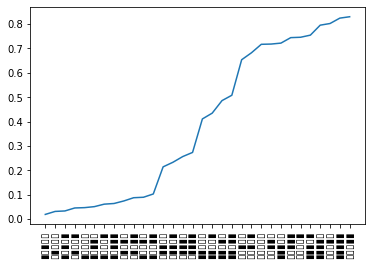

In [50]:
index = 4 
plt.plot(mean_cluster_responses[index, mcr_sort_indexes[index]])
plt.xticks(range(32), np.array(glyphs)[mcr_sort_indexes[index]], rotation=90);


[-0.874999999999999, -1.1249999999999991]


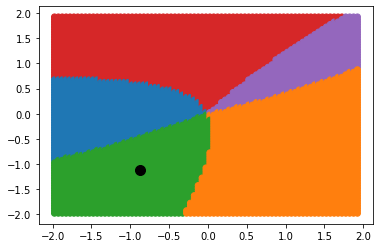

In [31]:

#print(pred_fit_coords[147650])
kmeans = KMeans(n_clusters=5)
kmeans.fit(np.array(all_pred_fits))
all_pred_fits = np.array(all_pred_fits)
pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == 2], axis=0)).sum(axis=-1))
print(pred_fit_coords[pc_coord_index])
cs = [mpl.cm.tab10(i) for i in kmeans.labels_]
plt.scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs)
plt.scatter(pred_fit_coords[pc_coord_index][0], pred_fit_coords[pc_coord_index][1], c='k', s=100)

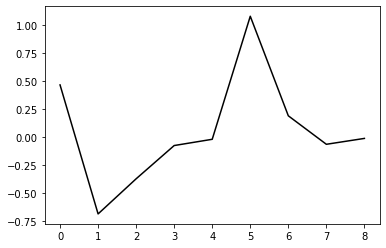

In [32]:
plt.plot(pca_all.components_[0]*pred_fit_coords[pc_coord_index][0] + pca_all.components_[1]*pred_fit_coords[pc_coord_index][1], c='k')

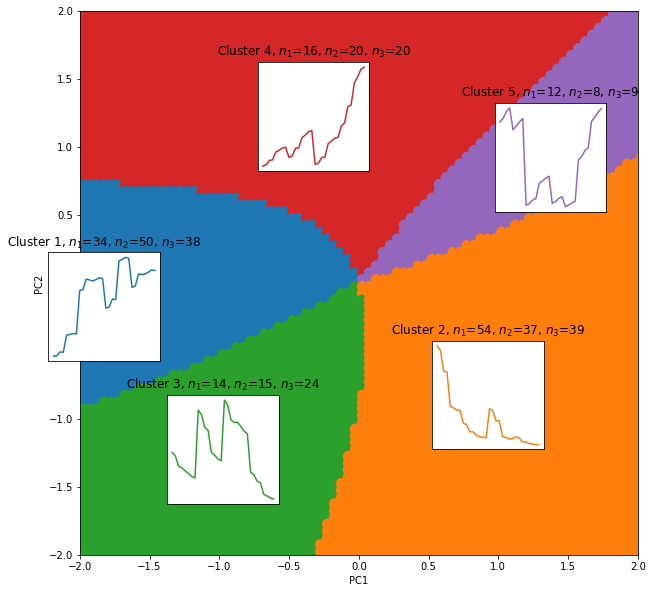

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(np.array(all_pred_fits))
cs = [mpl.cm.tab10(i) for i in kmeans.labels_]
ax.scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs, s=100)
all_pred_fits = np.array(all_pred_fits)
pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == 2], axis=0)).sum(axis=-1))
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
for i in range(5):
    pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == i], axis=0)).sum(axis=-1))
    sub_ax = ax.inset_axes([(pred_fit_coords[pc_coord_index][0]+1.5)/4, (pred_fit_coords[pc_coord_index][1]+1.5)/4, 0.2, 0.2])
    sub_ax.set_xticks([])
    sub_ax.set_yticks([])
    #sub_ax.plot(pca_all.components_[0]*pred_fit_coords[pc_coord_index][0] + pca_all.components_[1]*pred_fit_coords[pc_coord_index][1], c='k')
    sub_ax.plot(np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0), c=mpl.cm.tab10(i))
    sub_ax.set_title(f'Cluster {i+1}, $n_1$={len(np.where(kpreds[:130] == i)[0])}, $n_2$={len(np.where(kpreds[130:260] == i)[0])}, $n_3$={len(np.where(kpreds[260:] == i)[0])}')

(-2, 2)

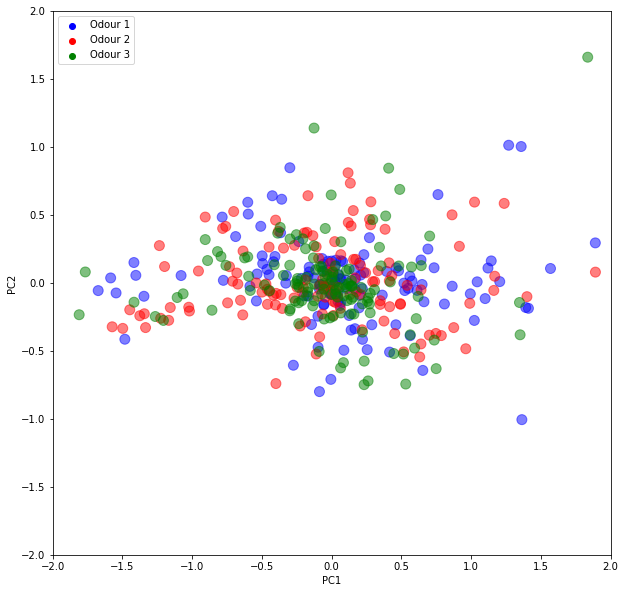

In [359]:
fig = plt.figure(figsize=(10, 10))
ocolors = ['b' for i in range(130)] + ['r' for i in range(130)] + ['g' for i in range(130)]
plt.scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], s=100, alpha=0.5, c=ocolors)
plt.scatter([], [],color='b', label='Odour 1')
plt.scatter([], [],color='r', label='Odour 2')
plt.scatter([], [],color='g', label='Odour 3')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

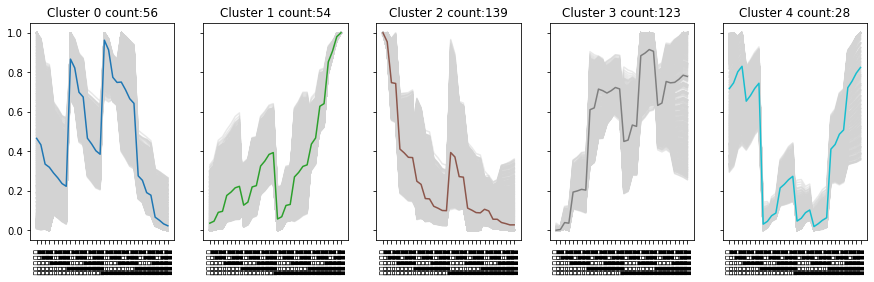

In [56]:
all_pred_fits = np.array(all_pred_fits)
all_ws = np.array(all_ws)
x_args = []
fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
kpreds = kmeans.predict(np.array(cell_pred_fit))
for j in range(5):
    for i in np.where(kmeans.labels_ == j)[0]:
        ax[j].plot(all_pred_fits[i], c='lightgray', alpha=0.5)
    ax[j].plot(np.mean(all_pred_fits[kmeans.labels_ == j], axis=0), c=mpl.cm.tab10(j/4))
    ax[j].set_xticks(range(32))
    ax[j].set_xticklabels(glyphs, rotation=90)
    ax[j].set_title(f'Cluster {j} count:{len(np.where(kpreds == j)[0])}')
    x_args.append(np.argsort(np.mean(all_pred_fits[kmeans.labels_ == j], axis=0)))

In [37]:
print(kpreds[:130])
print(np.where(kpreds[:130] != 0)[0])

[2 3 0 0 2 4 3 4 0 4 0 0 0 0 0 3 2 2 0 0 3 0 2 0 2 2 0 0 2 3 3 0 0 3 3 3 4
 4 4 4 3 0 0 2 2 3 1 3 3 1 1 1 1 1 3 3 3 3 1 3 1 2 3 1 3 1 3 1 2 4 3 3 0 2
 0 0 0 0 0 0 0 1 0 0 0 0 4 3 0 4 0 1 0 0 0 0 0 4 2 3 0 0 3 0 3 0 0 0 0 0 3
 4 0 3 0 0 0 0 0 0 3 0 1 3 3 3 0 1 1 3]
[  0   1   4   5   6   7   9  15  16  17  20  22  24  25  28  29  30  33
  34  35  36  37  38  39  40  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  73  81  86  87  89  91  97  98  99 102 104 110 111 113 120 122 123 124
 125 127 128 129]


In [285]:
unit_usrt_j = np.concatenate([unit_usrt1, unit_usrt2, unit_usrt3], axis=0)

def split_and_classify(usrt_scattered, unit_indexes, trial_indexes=range(32), scaled=True, shuffle=False, pcad=True, pca_count=1, classifier=RandomForestClassifier, classifier_params={}):
    train, test = ba.split_bs_data(usrt_scattered[unit_indexes])
    unit_count = len(unit_indexes)
    train_sum = train.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    test_sum = test.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    y_train = np.hstack([[i for j in range(60)] for i in trial_indexes])
    y_test = trial_indexes
    if scaled:
        scaler = StandardScaler()
        train_sum = scaler.fit_transform(train_sum)
        test_sum = scaler.transform(test_sum)
    svm = classifier(**classifier_params)
    if shuffle:
        np.random.shuffle(y_train)
    svm.fit(train_sum, y_train)
    return svm.score(test_sum, y_test), svm.predict(test_sum)

def classify_multiple(data, kpreds, repeat_number = 100, same_unit_limit=False, trial_indexes=range(32)):
    all_scores = []
    all_preds = []
    min_num_clusters = np.min([len(np.where(kpreds == i)[0]) for i in range(len(np.unique(kpreds)))])
    for j in range(len(np.unique(kpreds))):
        scores = []
        preds = []
        for i in trange(repeat_number, leave=False, position=0):
            unit_indexes = np.where(kpreds == j)[0]
            if same_unit_limit:
                unit_indexes = np.random.choice(unit_indexes, size=min_num_clusters, replace=False)
            score, pred = split_and_classify(data, unit_indexes, trial_indexes=trial_indexes)
            scores.append(score)
            preds.append(pred)
        all_scores.append(scores)
        all_preds.append(preds)
        print(j)
    return all_scores, all_preds

def plot_cms(all_preds, diff=False, set_vmax=False, trial_indexes=range(32)):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    cms = []
    ims = []
    for i in range(5):
        cm = confusion_matrix(np.concatenate([trial_indexes for j in range(100)]), np.concatenate(all_preds[i]), normalize='true')
        if diff:
            cm = cm - cm_j_true
            im = ax[i].imshow(cm, cmap='seismic', vmin=-np.max(np.abs(cm)), vmax=np.max(np.abs(cm)))
        else:
            im = ax[i].imshow(cm, cmap='plasma')
        #ax[i].set_title(f'Cluster {i} count:{len(np.where(kpreds == i)[0])}')
        cms.append(cm)
        ims.append(im)
    if set_vmax and not diff:
        [i.set_clim(0, np.max(cms)) for i in ims]
    if set_vmax and diff:
        [i.set_clim(-np.max(np.abs(cms)), np.max(np.abs(cms))) for i in ims]
    [plt.colorbar(ims[i], ax=ax[i]) for i in range(5)]
    plt.draw()
    #plt.show()
    return ax, cms

#split_and_classify(unit_usrt1, np.where(kpreds[:130] != 2)[0])

In [353]:
all_scores_limit, all_preds_limit = classify_multiple(unit_usrt_j, kpreds, repeat_number=100, same_unit_limit=True)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  0%|          | 0/100 [00:00<?, ?it/s]          

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


In [282]:
iti_scores_limit, iti_preds_limit = classify_multiple(unit_usrt_j, kpreds, repeat_number=100, same_unit_limit=True, trial_indexes=iti_trials)

  1%|          | 1/100 [00:00<00:18,  5.28it/s]  

0


  1%|          | 1/100 [00:00<00:18,  5.22it/s]  

1


  1%|          | 1/100 [00:00<00:18,  5.23it/s]  

2


  1%|          | 1/100 [00:00<00:19,  5.17it/s]  

3


4


In [292]:
onset_scores_limit, onset_preds_limit = classify_multiple(unit_usrt_j, kpreds, repeat_number=100, same_unit_limit=True, trial_indexes=onset_trials)
conc_scores_limit, conc_preds_limit = classify_multiple(unit_usrt_j, kpreds, repeat_number=100, same_unit_limit=True, trial_indexes=conc_trials)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  1%|          | 1/100 [00:00<00:19,  5.06it/s]  

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  1%|          | 1/100 [00:00<00:19,  5.04it/s]  

3


  0%|          | 0/100 [00:00<?, ?it/s]          

4


  0%|          | 0/100 [00:00<?, ?it/s]          

0


  1%|          | 1/100 [00:00<00:19,  5.00it/s]  

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


In [294]:
full_onset_scores, full_onset_preds = classify_multiple(unit_usrt_j, np.zeros(390), repeat_number=100, same_unit_limit=True, trial_indexes=onset_trials)

0


IndexError: list index out of range

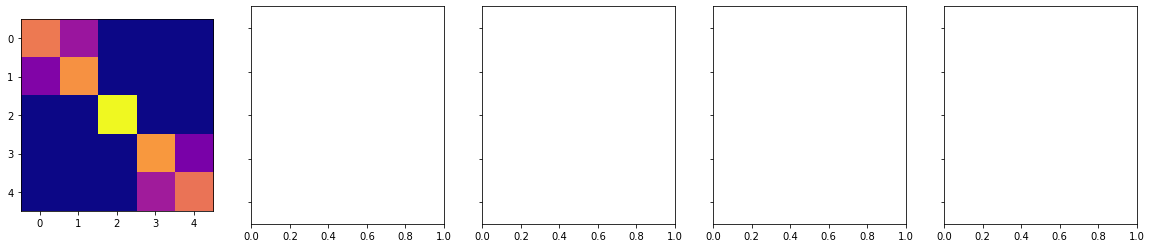

In [295]:
plot_cms(full_onset_preds, trial_indexes=onset_trials)

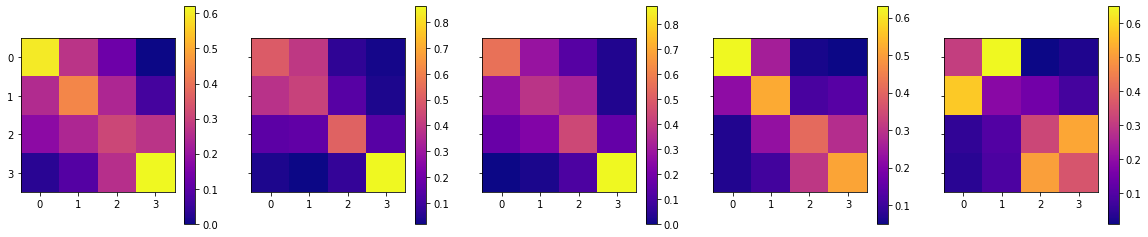

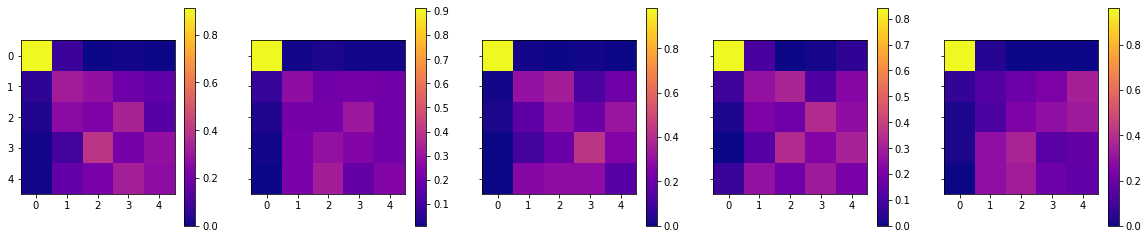

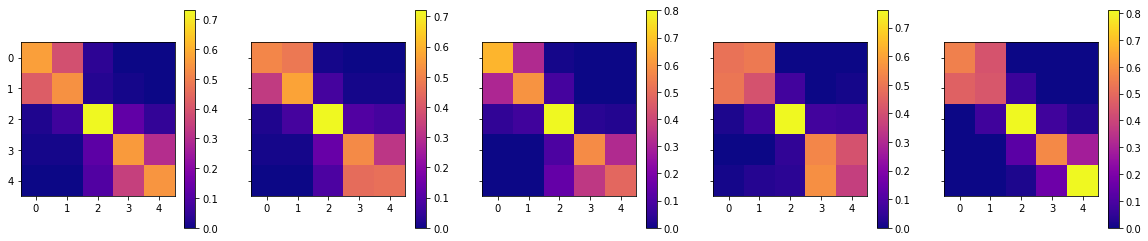

In [293]:
axs, cms = plot_cms(iti_preds_limit, set_vmax=False, trial_indexes=iti_trials)
axs, cms = plot_cms(conc_preds_limit, set_vmax=False, trial_indexes=conc_trials)
axs, cms = plot_cms(onset_preds_limit, set_vmax=False, trial_indexes=onset_trials)


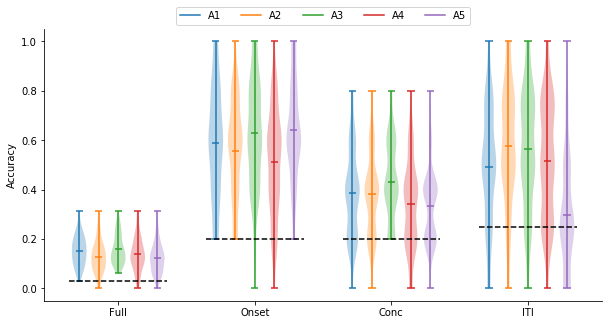

In [372]:
plt.figure(figsize=(10, 5))
pos1 = [-.2, 0.8, 1.8, 2.8, 3.8, 0, 1, 2, 3, 4, 0.2, 1.2, 2.2, 3.2, 4.2]
pos2 = [-.4, -.2, 0, .2, .4, 1, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3.0, 3.2]
pos3 = pos2 + [3.8, 4.0, 4.2, 4.4, 4.6]
vps = plt.violinplot(all_scores_limit + onset_scores_limit + conc_scores_limit + iti_scores_limit, showmeans=True, positions=pos3, widths=0.15)
plt.plot([], [], c='C0', label='A1')
plt.plot([], [], c='C1', label='A2')
plt.plot([], [], c='C2', label='A3')
plt.plot([], [], c='C3', label='A4')
plt.plot([], [], c='C4', label='A5')
colors = ['C0', 'C1', 'C2', 'C3', 'C4']*4
for pc, color in zip(vps['bodies'], colors):
    pc.set_facecolor(color)
for i in ['cmins', 'cmaxes', 'cmeans', 'cbars']:
    vps[i].set_color(colors)
plt.xticks([0, 1.4, 2.8, 4.2], labels=['Full', 'Onset', 'Conc', 'ITI'])

plt.ylabel('Accuracy')
plt.legend(ncol=5, bbox_to_anchor=(0.5, 1.1), loc='upper center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot([-0.5, .5], [1/32, 1/32], c='k', linestyle='--')
plt.plot([.9, 1.9], [1/5, 1/5], c='k' , linestyle='--')
plt.plot([2.3, 3.3], [1/5, 1/5], c='k', linestyle='--')
plt.plot([3.7, 4.7], [1/4, 1/4], c='k', linestyle='--')

In [289]:
print(np.array(iti_scores_limit).mean(axis=-1))

[0.4925 0.5775 0.5625 0.5175 0.2975]


In [100]:
all_scores_joined, all_preds_joined = classify_multiple(unit_usrt_j, kpreds, repeat_number=100, same_unit_limit=False)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  0%|          | 0/100 [00:00<?, ?it/s]          

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


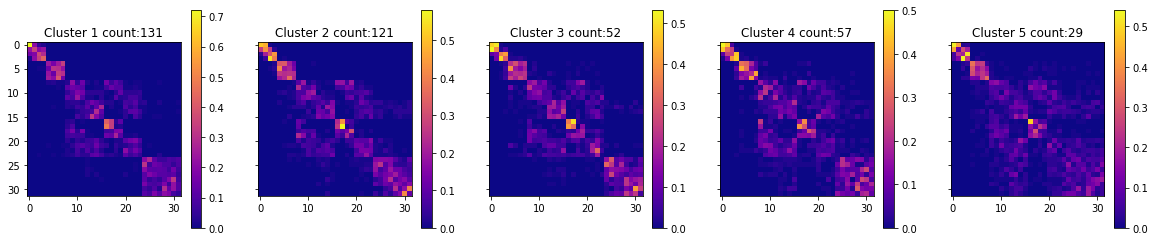

In [113]:
axs, cms = plot_cms(all_preds_joined, set_vmax=False)
[i.set_title(f'Cluster {index+1} count:{len(np.where(kpreds == index)[0])}') for index, i in enumerate(axs)]
plt.draw()
#plt.show()

[0.194375  0.188125  0.200625  0.1646875 0.124375 ]


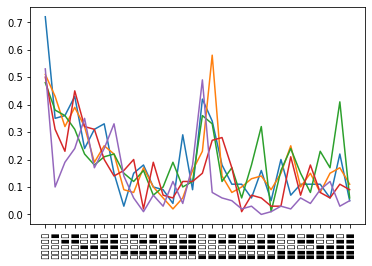

In [126]:
plt.plot(np.diag(cms[0]))
plt.plot(np.diag(cms[1]))
plt.plot(np.diag(cms[2]))
plt.plot(np.diag(cms[3]))
plt.plot(np.diag(cms[4]))
plt.xticks(range(32), labels=glyphs, rotation=90);
print(np.mean(all_scores_joined, axis=1))


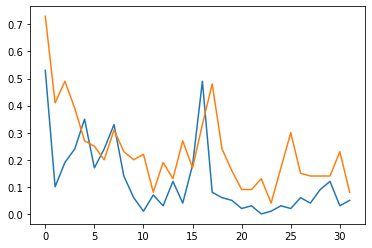

In [133]:
plt.plot(np.diag(cms[4]))
plt.plot(np.diag(cm_j_true))

([<matplotlib.axis.XTick at 0x7f11ba3dfdd8>,
 <a list of 6 Text xticklabel objects>)

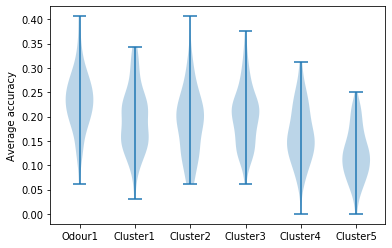

In [195]:
plt.violinplot([true_full_score] + all_scores_joined)
plt.ylabel('Average accuracy')
plt.xticks(range(1, 7), labels=['Odour1', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5'])


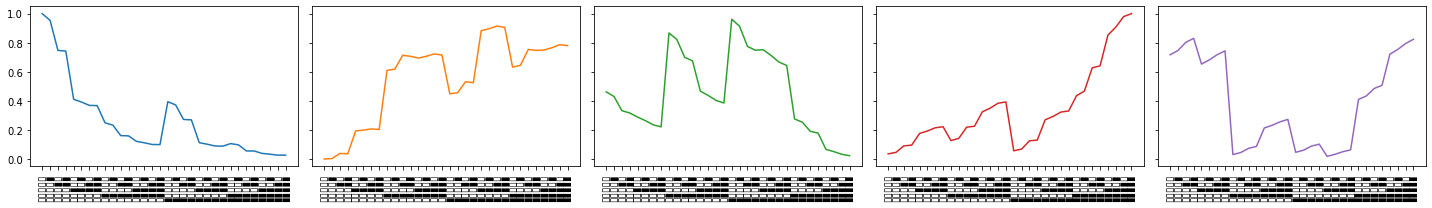

In [148]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3), sharey=True)
for i in range(5):
    ax[i].plot(np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0), c=mpl.cm.tab10(i))
    ax[i].set_xticks(range(32))
    ax[i].set_xticklabels(glyphs, rotation=90);
plt.tight_layout()

(390, 32)


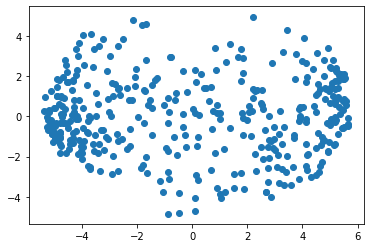

In [216]:
from sklearn.preprocessing import StandardScaler
print(mean_all_usrt.shape)

scaled_mean_all_usrt = StandardScaler().fit_transform(mean_all_usrt.T)
pca_usrt = PCA(n_components=10)
pcad_usrt = pca_usrt.fit_transform(scaled_mean_all_usrt.T)
#plt.plot(pca_usrt.explained_variance_ratio_)

plt.scatter(pcad_usrt[:, 0], pcad_usrt[:, 1])

3
(130, 32)


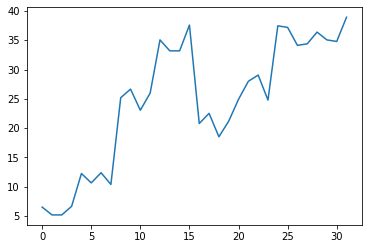

In [185]:
print(np.where(kpreds == 0)[0][1])
print(mean_usrt1.shape)
plt.plot(mean_all_usrt[np.where(kpreds == 1)[0][11]])

(-34.95, 733.95, -53.23607380929604, 1139.9575499952166)

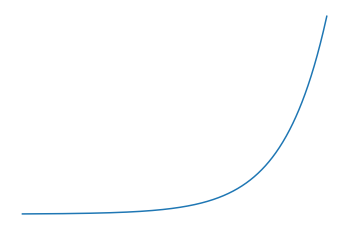

In [237]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(np.exp(np.arange(0, 7, 0.01)))
plt.axis('off')

In [239]:
from scipy.stats import poisson

(-2.45, 51.45, -0.0036317263234813355, 0.07626625279516672)

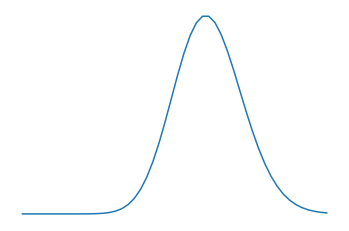

In [253]:
plt.plot(poisson.pmf(np.arange(0, 50), 30))
plt.axis('off')

In [13]:
all_scores_full = []
all_preds_full = []
for j in range(5):
    scores = []
    preds = []
    for i in trange(100, leave=False, position=0):
        score, pred = split_and_classify(unit_usrt1, np.where(kpreds[:130] == j)[0])
        scores.append(score)
        preds.append(pred)
    all_scores_full.append(scores)
    all_preds_full.append(preds)
    print(j)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  0%|          | 0/100 [00:00<?, ?it/s]          

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


In [148]:
all_scores_nfull = []
all_preds_nfull = []
for j in range(5):
    scores = []
    preds = []
    for i in trange(100, leave=False, position=0):
        score, pred = split_and_classify(unit_usrt1, np.where(kpreds[:130] != j)[0])
        scores.append(score)
        preds.append(pred)
    all_scores_nfull.append(scores)
    all_preds_nfull.append(preds)
    print(j)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  0%|          | 0/100 [00:00<?, ?it/s]          

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


In [35]:
all_scores_joined = []
all_preds_joined = []
unit_usrt_j = np.concatenate([unit_usrt1, unit_usrt2, unit_usrt3], axis=0)
for j in range(5):
    scores = []
    preds = []
    for i in trange(100, leave=False, position=0):
        score, pred = split_and_classify(unit_usrt_j, np.where(kpreds == j)[0])
        scores.append(score)
        preds.append(pred)
    all_scores_joined.append(scores)
    all_preds_joined.append(preds)
    print(j)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  0%|          | 0/100 [00:00<?, ?it/s]          

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


In [40]:
true_full_score = []
true_full_pred = []
for i in trange(100, leave=False, position=0):
    score, pred = split_and_classify(unit_usrt_j, np.arange(390))
    true_full_score.append(score)
    true_full_pred.append(pred)

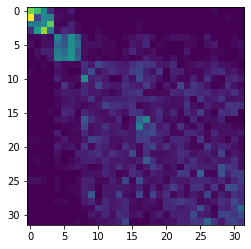

In [69]:

cm = confusion_matrix(np.concatenate([range(32) for i in range(100)]), np.concatenate(all_preds[4]))
plt.imshow(cm)

0.2328125
0.245


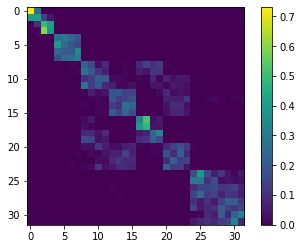

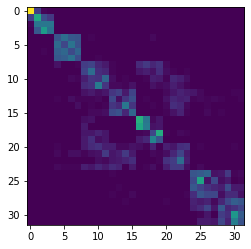

In [50]:
cm_j_true = confusion_matrix(np.concatenate([range(32) for i in range(100)]), np.concatenate(true_full_pred), normalize='true')
plt.imshow(cm_j_true)
plt.colorbar()
plt.figure()
plt.imshow(cm_true1)
print(np.mean(true_full_score))
print(np.diag(cm_true1).mean())

In [37]:
print(np.mean(all_scores_full, axis=-1))

[0.1675    0.15875   0.115625  0.1309375 0.0834375]


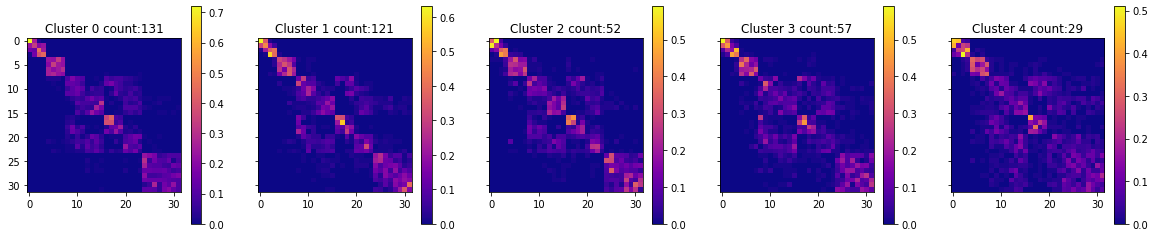

In [38]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

cms = []
ims = []
for i in range(5):
    cm = confusion_matrix(np.concatenate([range(32) for j in range(100)]), np.concatenate(all_preds_joined[i]), normalize='true')
    im = ax[i].imshow(cm, cmap='plasma')
    ax[i].set_title(f'Cluster {i} count:{len(np.where(kpreds == i)[0])}')
    cms.append(cm)
    ims.append(im)
#[i.set_clim(0, np.max(cms)) for i in ims]
[plt.colorbar(ims[i], ax=ax[i]) for i in range(5)]
plt.draw()
plt.show()

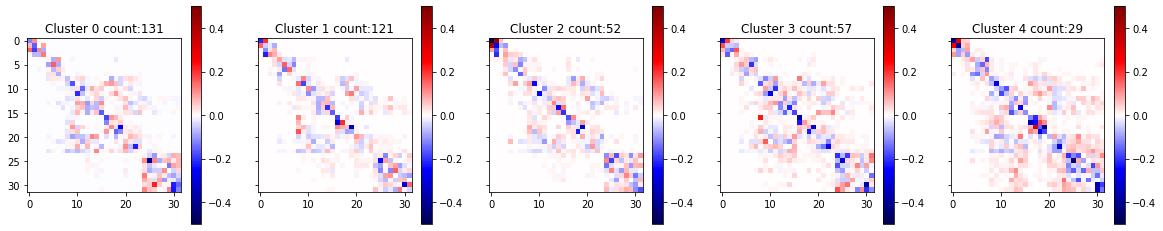

In [39]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
cms = []
ims = []
for i in range(5):
    cm = confusion_matrix(np.concatenate([range(32) for j in range(100)]), np.concatenate(all_preds_joined[i]), normalize='true')
    im = ax[i].imshow(cm - cm_true1, cmap='seismic')
    ax[i].set_title(f'Cluster {i} count:{len(np.where(kpreds == i)[0])}')
    cms.append(cm - cm_true1)
    ims.append(im)
[i.set_clim(-np.max(np.abs(cms)), np.max(np.abs(cms))) for i in ims]
[plt.colorbar(ims[i], ax=ax[i]) for i in range(5)]
plt.draw()
plt.show()

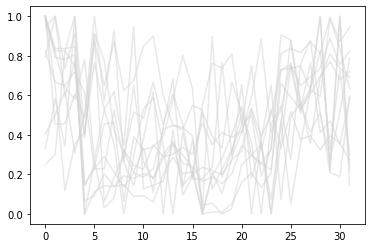

In [147]:
for i in np.where(kpreds[:130] == 4)[0]:
    plt.plot(norm_mean_all_usrt[i], c='lightgray', alpha=0.5)

(-2.5352295087451475, 2.5352295087451475)

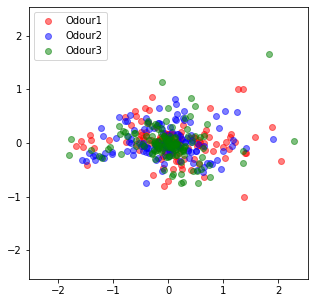

In [171]:
plt.figure(figsize=(5, 5))
plt.scatter(fit_bins_all[:130, 0], fit_bins_all[:130, 1], c='r', alpha=0.5, label='Odour1')
plt.scatter(fit_bins_all[130:260, 0], fit_bins_all[130:260, 1], c='b', alpha=0.5, label='Odour2')
plt.scatter(fit_bins_all[260:390, 0], fit_bins_all[260:390, 1], c='g', alpha=0.5, label='Odour3')
plt.legend()
max_lim = np.max(np.abs(plt.xlim() + plt.ylim()))
plt.xlim(-max_lim, max_lim)
plt.ylim(-max_lim, max_lim)

In [151]:
ints = []
silhs = []
for i in range(2, 15):
    kms = KMeans(n_clusters=i)
    kms.fit(norm_mean_all_usrt)
    ints.append(kms.inertia_)
    silhs.append(silhouette_score(norm_mean_all_usrt, kms.labels_))

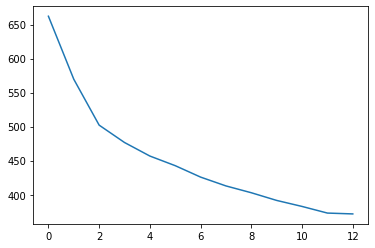

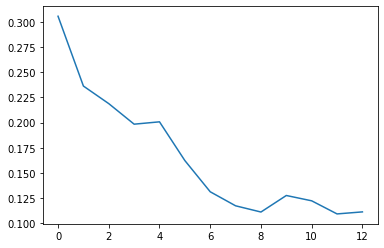

In [152]:
plt.plot(ints)
plt.figure()
plt.plot(silhs)

In [153]:
kms = KMeans(n_clusters=5)
kms.fit(norm_mean_all_usrt)

KMeans(n_clusters=5)

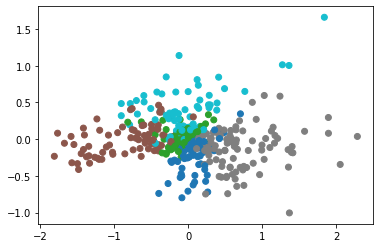

In [156]:
plt.scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], c=kms.labels_, cmap='tab10')

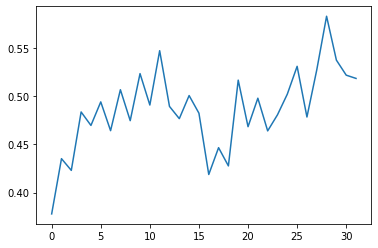

In [163]:
plt.plot(np.mean(norm_mean_all_usrt[kms.labels_ == 1], axis=0))

In [136]:
print(np.where(kpreds[:130] == 0)[0])

[  2   3   8  10  11  12  13  14  18  19  21  23  26  27  31  32  41  42
  72  74  75  76  77  78  79  80  82  83  84  85  88  90  92  93  94  95
  96 100 101 103 105 106 107 108 109 112 114 115 116 117 118 119 121 126]


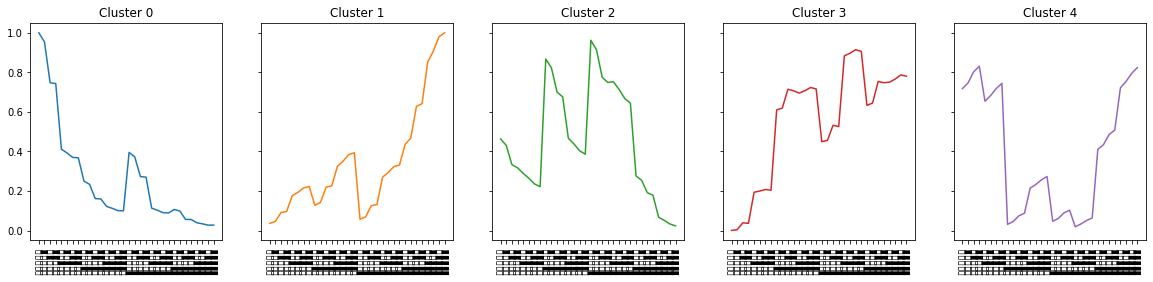

In [110]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for i in range(5):
    ax[i].plot(np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0), c=mpl.cm.tab10(i))
    ax[i].set_xticks(range(32))
    ax[i].set_xticklabels(glyphs, rotation=90)
    ax[i].set_title(f'Cluster {i}')

In [16]:
full_res = pickle.Unpickler(open('../Fig3/230315_full_classifier_RFs.pkl', 'rb')).load()
scores = full_res[:, :, 0].astype(float)
preds = full_res[:, :, 1]
preds_corrected = np.array([[np.stack(i) for i in j] for j in preds])
preds_flat = preds_corrected.reshape((preds_corrected.shape[0], preds_corrected.shape[1] * preds_corrected.shape[2]))
trues = [i for j in range(100) for i in range(32)]
cms_true = np.array([confusion_matrix(trues, preds_flat[i], normalize='true') for i in range(3)])
cm_true1 = cms_true[0]

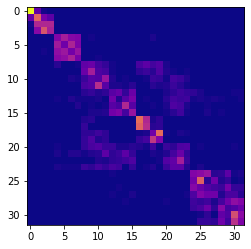

In [118]:
plt.imshow(cms[0], cmap='plasma')

In [104]:
kpreds_clusters = [np.where(kpreds[:130] == i)[0] for i in range(5)]
max_count = np.min([len(i) for i in kpreds_clusters])#
all_scores = []
all_preds = []
for j in range(5):
    scores = []
    preds = []
    for i in trange(100, leave=False, position=0):
        score, pred = split_and_classify(unit_usrt1, np.random.choice(kpreds_clusters[j], max_count, replace=False))
        scores.append(score)
        preds.append(pred)
    all_scores.append(scores)
    all_preds.append(preds)
    print(j)

  0%|          | 0/100 [00:00<?, ?it/s]          

0


  0%|          | 0/100 [00:00<?, ?it/s]          

1


  0%|          | 0/100 [00:00<?, ?it/s]          

2


  0%|          | 0/100 [00:00<?, ?it/s]          

3


4


In [95]:
dasked = Daskified(memory="16GB")
dasked.start_cluster()

In [96]:
usrt_scattered1 = dasked.client.scatter(unit_usrt1)
usrt_scattered2 = dasked.client.scatter(unit_usrt2)
usrt_scattered3 = dasked.client.scatter(unit_usrt3)


In [ ]:
delayeds = []
for j in range(5):
    for k in range(5):
        
    scores = []
    preds = []
    for i in trange(100, leave=False, position=0):
        score, pred = split_and_classify(unit_usrt1, np.where(kpreds[:130] == j)[0])
        scores.append(score)
        preds.append(pred)
    all_scores.append(scores)
    all_preds.append(preds)
    print(j)

Text(0.5, 1.0, 'Silhouette Score')

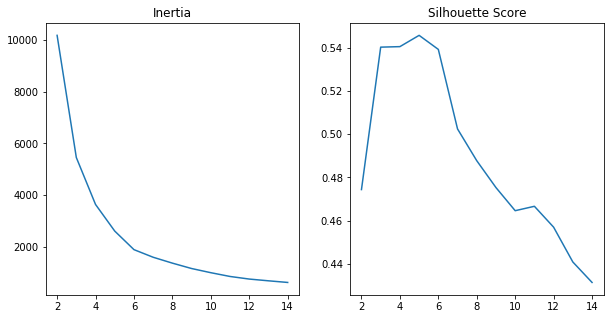

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(2, 15), inerts)
ax[1].plot(range(2, 15), silhs)
ax[0].set_title('Inertia')
ax[1].set_title('Silhouette Score')

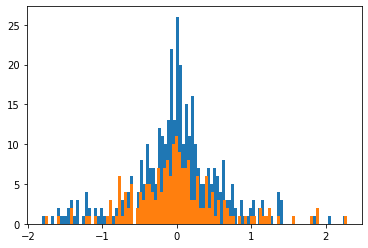

In [42]:
def find_quartile_counts(coefficient_array, quartile_range=np.arange(0, 1.1, 0.1)):
    for index, i in enumerate(quartile_range):
        for jndex, j in enumerate(quartile_range):
            count = coefficient_array[]

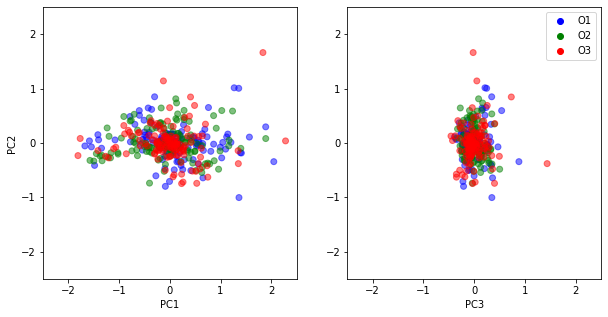

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], alpha=0.5, c=colors)

max_lims = np.max(np.concatenate([np.abs(ax[0].get_xlim()), np.abs(ax[0].get_ylim())]))
ax[0].set_xlim([-max_lims, max_lims])
ax[0].set_ylim([-max_lims, max_lims])

ax[1].scatter(fit_bins_all[:, 2], fit_bins_all[:, 1], alpha=0.5, c=colors)
ax[1].set_xlim([-max_lims, max_lims])
ax[1].set_ylim([-max_lims, max_lims])
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC3')
plt.scatter([], [], color='b', label='O1')
plt.scatter([], [], color='g', label='O2')
plt.scatter([], [], color='r', label='O3')
plt.legend()

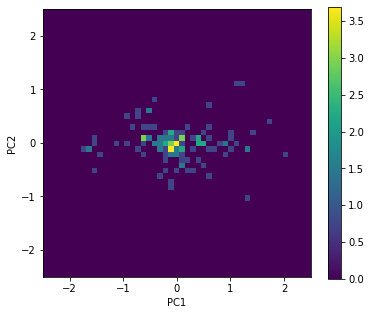

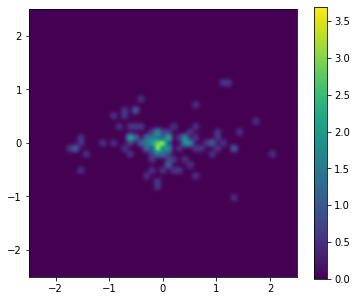

In [21]:
plt.figure(figsize=(6, 5))
h, x, y, p  = plt.hist2d(fit_bins1[:, 0], fit_bins1[:, 1], bins=[np.linspace(-2.5, 2.5, 50), np.linspace(-2.5, 2.5, 50)], density=True);
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.figure(figsize=(6, 5))
plt.imshow(h.T, extent=[x[0], x[-1], y[0], y[-1]], origin='lower', interpolation='gaussian')
plt.colorbar()

In [153]:
print(np.argsort(fit_bins_all[:, 0]))
print(np.argsort(fit_bins_all[:, 1]))

[274 362 165 102  40  87  48 225 347 215  35 226 281 359 218  34 224  47
 229 294 223 217 144 232  99 151 154 278 284  49 178 285 122 302 345 164
 148 123 279 252 161 354 208 253 228 153 234 186 348 155 355 364 163  45
  51 150 358 104 125 120  62  33  54 143 293 158 214 189 288 110  56  91
 159  29 250 196 289 179 113 342 344 273 184 145 168 185 309 142  81 353
 276 160 157  59 198  50  70 360 270  98 304  71 301  55 310 174 349  16
 328 308 219 141 388 326 135 255 303 187  30 318   7 298 319 286 258 146
   5  66 192 171 212  20 331  28 233 315   1 272 127 129  68  43 128 139
 134 137 275 356 264 290  22 340 173  44   8 147  53 201  58 277 305 132
 265 317 194 357 280  15 385 131 230 267 257 202 124  73 221 203  24 330
 324 338 152 130  17 266  19  57  46  60 254 336 333 321 269   4  64 327
 283 136 191 322 220 133 339  63   6 262  41  61 379  25 292 316 384 314
   0  11 271 172 140  26  67  65   9  12   2 361 337 295 323 197 138 320
 268  13  23 346  32 350 213  86 112  52 175  18 18

In [93]:
print(np.argsort(fit_bins1[:,0]))
print(np.argsort(fit_bins1[:, 1]))


[102  40  87  48  35  34  47  99  49 122 123  51  45 120 125 104  62  54
  33  91  56 110  29 113  81  59  50  70  71  55  16  98  30   5   7   1
  66 128  20 127 129  28  53  68  58  22  43   8 124  15  44  73  60  57
  46  17  24   4  19  64  63   6  61   0  67  11  25  26  65  41   9   2
  12  32  13  52  86  23 112  89  14  18  97  84  77  42  69  21  82   3
  74  38  31 108 105  83 111  92  72 107  75  78 103  27  79  10 109 100
  80 116 106 118 114  39  90  94 101 117 115  93  37 119  96  36  76  85
 121  88  95 126]
[ 44 121 109  43  24  98  41  31  35 126 107  18  25  23  27  68 102  21
  74  19  92   8  90 115  83 116   2 128  34  84  73  26 110 100  87  76
  61  48  16  12  17  42  40  11  28  45   7  77  85  82  66   4  56 105
  13  69  14   0  20 119  15  99  65  10 103   9 129 104  96 127  32  79
 114 112  64  22  30  57  72  89  49  62 117 111  54  58  80  67  47 108
  75  86   1  46  63   6 101   3  60  70  52 113  33  29 125  78  94 124
  93   5  88 106  97 118  53 123 

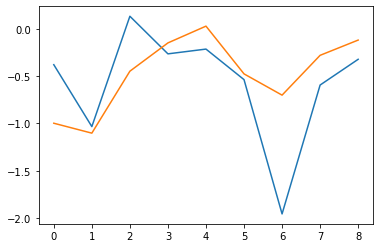

In [167]:
ui = 380
# plt.plot(bins1[ui])
# plt.plot(bins_1_pc12[ui])
plt.plot(all_bins[ui])
plt.plot(bins_all_pc12[ui])

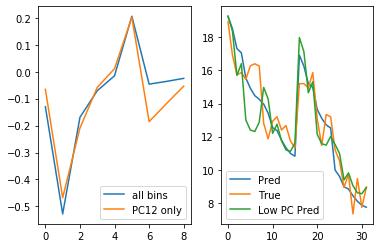

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ui = 41
ax[0].plot(all_bins[ui], label='all bins')
ax[0].plot(bins_all_pc12[ui], label='PC12 only')
ax[0].legend()

ax[1].plot(all_preds[ui], label='Pred')
ax[1].plot(all_trues[ui], label='True')
ax[1].plot(all_low_pc_pred[ui], label='Low PC Pred')
ax[1].legend()


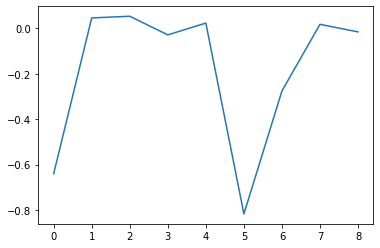

In [111]:
plt.plot(pca.components_[0]+pca.components_[1]*0.4)


In [9]:
## Loading in the sorted args of the responsive cell fits to other odours
minfrac_args = np.load('230516_minfracs_args_all_responsive.npy')

(-2.565188985143151, 2.565188985143151)

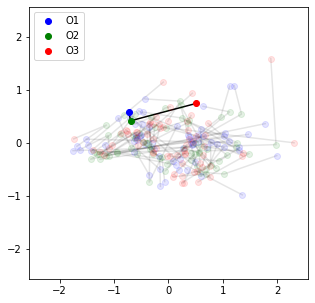

In [168]:

si = 1
all_but_select_cells = np.array(all_responsive_cells)[np.arange(66) != minfrac_args[si]]
select_cell = np.array(all_responsive_cells)[minfrac_args[si]]

plt.figure(figsize=(5, 5))
for i in all_but_select_cells:
    plt.plot([fit_bins1[i, 0], fit_bins2[i, 0], fit_bins3[i, 0]], [fit_bins1[i, 1], fit_bins2[i, 1], fit_bins3[i, 1]], c='k', zorder=-10, alpha=0.1)
plt.scatter(fit_bins1[all_but_select_cells, 0], fit_bins1[all_but_select_cells, 1], alpha=0.1, c='b')
plt.scatter(fit_bins2[all_but_select_cells, 0], fit_bins2[all_but_select_cells, 1], alpha=0.1, c='g')
plt.scatter(fit_bins3[all_but_select_cells, 0], fit_bins3[all_but_select_cells, 1], alpha=0.1, c='r')

plt.scatter(fit_bins1[select_cell, 0], fit_bins1[select_cell, 1], alpha=1, c='b', label='O1')
plt.scatter(fit_bins2[select_cell, 0], fit_bins2[select_cell, 1], alpha=1, c='g', label='O2')
plt.scatter(fit_bins3[select_cell, 0], fit_bins3[select_cell, 1], alpha=1, c='r', label='O3')
plt.legend()
plt.plot([fit_bins1[select_cell, 0], fit_bins2[select_cell,0], fit_bins3[select_cell, 0]], [fit_bins1[select_cell, 1], fit_bins2[select_cell, 1], fit_bins3[select_cell, 1]], c='k', zorder=0)
max_lims = np.max(np.concatenate([np.abs(plt.xlim()), np.abs(plt.ylim())]))
plt.xlim([-max_lims, max_lims])
plt.ylim([-max_lims, max_lims])

In [134]:
print(len(all_responsive_cells))
print(minfrac_args)

66
[65 62 61 47 46  7 44  9 42 33 23 37 19 60 56 34 32 45 54 29 11 48 39 27
 40 50 38 28 35 43 26 30 12 24 21 10  2 13  8 55 49 15 57 20 16  5 36  1
 18  3 22 59 58 25 14  0 17 64 52 31 63 41  6 53  4 51]


In [143]:
print(select_cell)

122


In [144]:
print(all_but_select_cells)

[ 18  21  24  25  28  29  30  31  33  34  36  37  38  39  40  43  44  47
  48  50  51  55  56  59  71  72  74  75  76  80  81  83  85  87  88  91
  92  93  94  95  96  98  99 102 103 104 105 106 107 108 109 110 111 113
 114 115 116 117 118 119 120 121 123 125 126]


In [10]:
print(np.arccos(np.dot(fit_bins1[select_cell], fit_bins2[select_cell])/(np.linalg.norm(fit_bins1[select_cell])*np.linalg.norm(fit_bins2[select_cell])))/np.pi*180)
print(np.arccos(np.dot(fit_bins1[select_cell], fit_bins3[select_cell])/(np.linalg.norm(fit_bins1[select_cell])*np.linalg.norm(fit_bins3[select_cell])))/np.pi*180)

NameError: name 'select_cell' is not defined

In [16]:
o1o2_angs = []
o1o3_angs = []
o1o2_2pcs_angs = []
o1o3_2pcs_angs = []
for si in range(66):
    select_cell = np.array(all_responsive_cells)[minfrac_args[si]]
    o1o2_ang = np.arccos(np.dot(fit_bins1[select_cell], fit_bins2[select_cell])/(np.linalg.norm(fit_bins1[select_cell])*np.linalg.norm(fit_bins2[select_cell])))
    o1o3_ang = np.arccos(np.dot(fit_bins1[select_cell], fit_bins3[select_cell])/(np.linalg.norm(fit_bins1[select_cell])*np.linalg.norm(fit_bins3[select_cell])))
    if o1o2_ang > np.pi/2:
        o1o2_ang = np.pi - o1o2_ang 
    if o1o3_ang > np.pi/2:
        o1o3_ang = np.pi - o1o3_ang
    o1o2_angs.append(o1o2_ang)
    o1o3_angs.append(o1o3_ang)

    o1o2_ang_2pcs = np.arccos(np.dot(fit_bins1[select_cell, :2], fit_bins2[select_cell, :2])/(np.linalg.norm(fit_bins1[select_cell, :2])*np.linalg.norm(fit_bins2[select_cell, :2])))
    o1o3_ang_2pcs = np.arccos(np.dot(fit_bins1[select_cell, :2], fit_bins3[select_cell, :2])/(np.linalg.norm(fit_bins1[select_cell, :2])*np.linalg.norm(fit_bins3[select_cell, :2])))
    if o1o2_ang_2pcs > np.pi/2:
        o1o2_ang_2pcs = np.pi - o1o2_ang_2pcs
    if o1o3_ang_2pcs > np.pi/2:
        o1o3_ang_2pcs = np.pi - o1o3_ang_2pcs

    o1o2_2pcs_angs.append(o1o2_ang_2pcs)
    o1o3_2pcs_angs.append(o1o3_ang_2pcs)

In [24]:
print(len(minfrac_args))

66


Text(0.5, 0, 'Cells')

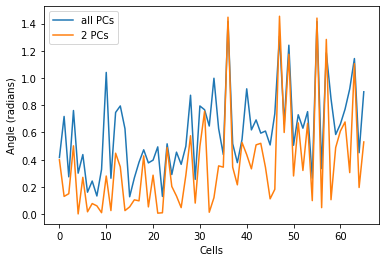

In [17]:
plt.plot(np.min([o1o2_angs, o1o3_angs], axis=0), label='all PCs')
plt.plot(np.min([o1o2_2pcs_angs, o1o3_2pcs_angs], axis=0), label='2 PCs')
plt.ylabel('Angle (radians)')
plt.legend()
plt.xlabel('Cells')

In [23]:
print(np.corrcoef([o1o2_2pcs_angs, o1o3_2pcs_angs, np.arange(66)]))


[[1.         0.17525317 0.36348173]
 [0.17525317 1.         0.31613543]
 [0.36348173 0.31613543 1.        ]]


In [175]:
print(np.pi/2)

1.5707963267948966


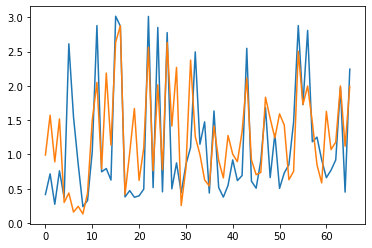

In [176]:
plt.plot(o1o2_angs)
plt.plot(o1o3_angs)

In [179]:
print(np.dot([0, -1], [0, 1]))

-1
